# **Agricultural drought in central South America - exploratory analysis**

- use 1980-2010 to calibrate - this period exists in ERA5, CPC, MSWEP
- under the [standard drought classification](https://droughtmonitor.unl.edu/About/AbouttheData/DroughtClassification.aspx) we're interested in moderate droughts (threshold 0.8). Classify as a drought month if below -0.8, drought ends when > -0.8 (NOT over zero) for two or more months.
- see Reddy & Ganguli, application of copulas for derivation of drought severity–duration–frequency curves


Still to check/do:
- for SPI3, should drought severity be computed by summing all monthly values, or three-monthly?
- filtering of arid regions needed (exclude >0.25% zero values; prcptot/pet <= 0.05)

In [2]:
import sys; sys.path.append('/home/clair/wwa'); from wwa import *; from wwa_indices import get_spi

from xclim.indices.stats import fit
from xclim.indices.run_length import rle
from xclim.indices.run_length import _cumsum_reset_on_zero as run_cumsum


import lmoments3.distr                     # conda activate xclim; pip install git+https://github.com/OpenHydrology/lmoments3.git
glo = getattr(lmoments3.distr, "glo")

import warnings
warnings.filterwarnings("ignore", message = "overflow encountered in exp.+")                           # warning about change to Cartopy plotting defaults

## **Exploratory**

### **Data pre-processing**

#### **Trim ERA5 to S America land surface, update with January data**

In [122]:
# trim data & save as monthly
lsm = xr.open_dataset("../../Data/era5/era5_lsm_025.nc").squeeze(drop = True).lsm.sel(latitude = slice(-10,-50), longitude = slice(280,320)).rename(longitude = "lon", latitude = "lat")

pr_m = decode_times(xr.open_dataset("data/era5_tp_-80--40E_-50--10N_su.nc", decode_times = False)).tp
pr_jan = convert_units_to(xr.open_dataset("data/era5_tp_-80--40E_-50--10E_january-hourly.nc").tp, "mm").rename(latitude = "lat", longitude = "lon")
pr_jan = pr_jan.resample(time = "D").sum().resample(time = "MS").mean()
pr_jan["lon"] = pr_jan.lon + 360
pr = xr.concat([pr_m, pr_jan], "time").rename("precip").where(lsm >= 0.5)
pr.to_netcdf("data/era5_precip_monthly.nc")

In [122]:
# PET also used to compute SPEI in exploratory analysis - but not updated with latest data, since using SPI instead
# decode_times(xr.open_dataset("data/era5_evap_-80--40E_-50--10N_su.nc", decode_times = False)).evap.rename("pet").where(lsm >= 0.5).to_netcdf("data/era5_pet_monthly.nc")

#### **CPC monthly files & PET**

In [2]:
from xclim.indices import potential_evapotranspiration

# trim precip & aggregate to monthly
xr.open_mfdataset("../../Data/cpc/precip.*.nc").sel(lat = slice(-10,-50), lon = slice(280,320)).precip.resample(time = "MS").mean().to_netcdf("data/cpc_precip_monthly.nc")

# compute mean temps, save for later plotting
tmin = xr.open_mfdataset("../../Data/cpc/tmin.*.nc").sel(lat = slice(-10,-50), lon = slice(280,320)).tmin
tmax = xr.open_mfdataset("../../Data/cpc/tmax.*.nc").sel(lat = slice(-10,-50), lon = slice(280,320)).tmax
tas = (tmax + tmin) / 2
tas.resample(time = "MS").mean().rename("tas").to_netcdf("data/cpc_tas_monthly.nc")

# compute PET using Hargreaves - McGuinness-Bordne has an issue in Dec/Jan
pet = convert_units_to(potential_evapotranspiration(tasmin = tmin, tasmax = tmax, method = "HG85").rename("pet").resample(time = "MS").mean(), "mm/day")
pet.to_netcdf("data/cpc_pet_monthly.nc")

In [4]:
# compute mean temps, save for later plotting
tmin = xr.open_mfdataset("../../Data/cpc/tmin.*.nc").sel(lat = slice(-10,-50), lon = slice(280,320)).tmin
tmax = xr.open_mfdataset("../../Data/cpc/tmax.*.nc").sel(lat = slice(-10,-50), lon = slice(280,320)).tmax
tas = (tmax + tmin) / 2

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())
rm = regionmask.mask_3D_geopandas(sf, tas.lon, tas.lat).squeeze(drop = True)

In [7]:
tas.where(rm).mean(["lat", "lon"]).rename("tas").to_netcdf("data/cpc-tas_CSA_daily.nc")

In [291]:
xr.open_mfdataset("../../Data/cpc/precip.*.nc").sel(lat = slice(-10,-50), lon = slice(280,320)).precip.resample(time = "MS").mean().to_netcdf("data/cpc_precip_monthly.nc")

#### **Flatten data for processing in R**

In [59]:
# flatten data for processing in R
for ens in ["era5", "cpc"]:

    # precipitation
    pr = xr.open_dataset("data/"+ens+"_precip_monthly.nc").precip
    pr = pr.where(np.isnan(pr).sum("time") < 100)
    pr.stack(xy = ["lat", "lon"]).to_pandas().to_csv("data/"+ens+"_pr_monthly.csv")
    
    # effective precipitation
    pet = xr.open_dataset("data/"+ens+"_pet_monthly.nc").pet
    eff_pr = (pr - pet).where(np.isnan(pr).sum("time") < 100)
    eff_pr.stack(xy = ["lat", "lon"]).to_pandas().to_csv("data/"+ens+"_eff-pr_monthly.csv")

#### **CHIRPS (for SPI & precip only)**

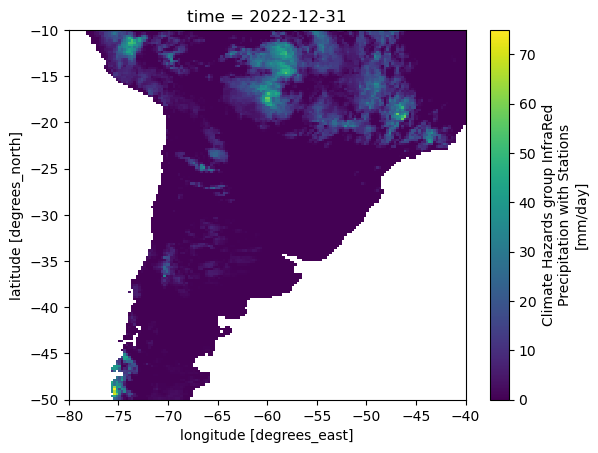

In [5]:
pr = xr.open_mfdataset("../../Data/chirps/chirps-v2.0.*.days_p25.nc").precip.sel(latitude = slice(-50,-10), longitude = slice(280-360,320-360))
pr.resample(time = "MS").mean().rename(latitude = "lat", longitude = "lon").to_netcdf("data/chirps_precip_monthly.nc")

In [56]:
# Create daily time series
pr = xr.open_mfdataset("../../Data/chirps/chirps-v2.0.*.days_p25.nc").precip.sel(latitude = slice(-50,-10), longitude = slice(280-360,320-360))

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())
rm = regionmask.mask_3D_geopandas(sf, pr.longitude, pr.latitude).squeeze(drop = True)

pr.where(rm).mean(["latitude", "longitude"]).to_netcdf("data/chirps_CSA_daily.nc")

#### **MSWEP (for SPI & precip only)**

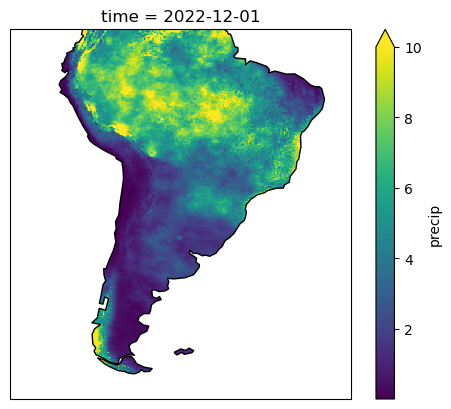

In [2]:
pr = xr.concat([xr.open_dataset(fnm).expand_dims(time = [np.datetime64(fnm[-7:-3]+"-12-01")]) for fnm in sorted(glob.glob("tmp/*.nc"))], "time").precip.assign_coords(lat = np.arange(-60,5,0.1), lon = np.arange(-90, -30, 0.1))
rm = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask_3D(pr.lon, pr.lat)
pr = pr.where(rm == 1).squeeze(drop = True)
pr.to_netcdf("data/mswep_precip_monthly.nc")

# compute SPI for OND precip & save
pr = xr.open_dataset("data/mswep_precip_monthly.nc").sel(lat = slice(-50,-10), lon = slice(280-360,320-360)).precip
spi = get_spi(pr, months = [12])
spi.to_netcdf("data/mswep_spi3_monthly.nc")

In [2]:
pr = xr.open_dataset("data/mswep_precip_monthly.nc").sel(lat = slice(-50,-10), lon = slice(280-360,320-360)).precip
spi = get_spi(pr, months = [12])
spi.to_netcdf("data/mswep_spi3_monthly.nc")

---
### **Compute drought indices**

---
#### **SPI**

In [42]:
for ens in ["chirps"]:#["era5", "cpc"]:
    
    pr = xr.open_dataset("data/"+ens+"_precip_monthly.nc").precip
    pr_n = pr.rolling(time = 3, center = False).mean(keep_attrs = False)
    pr_n = pr_n.where(np.isnan(pr_n).sum("time") < 100)                          # skip any cells with high proportion of missing data

    spi_monthly = []
    # fit each calendar month in turn - only really interested in Oct/Nov/Dec/Jan so excluding other months to avoid dealing with dry periods
    for i in [9,10,11,0]:
        
        # select current calendar month
        pr_m = pr_n.sel(time = pr_n.time.dt.month == i+1)
        
        # estimate parameters over calibration period
        pr_cal = pr_m.sel(time = slice("1980", "2010")).copy()
        pars = fit(pr_cal.dropna("time", "all"), dist = "gamma", method = "PWM")
        
        # normalise all values using fitted parameters
        spi_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(gamma.cdf(pr, *dparams)), pr_m, pars, 
                               input_core_dims = [["time"],["dparams"]], output_core_dims = [["time"]], vectorize = True).assign_coords(time = pr_m.time)
        
        # replace +ve (-ve) infinite values with finite maximum (minimum) in each grid cell
        spi_finite = xr.concat([spi_m.where(~np.isinf(spi_m)), 
                                xr.ones_like(spi_m).where(spi_m == np.inf) * spi_m.where(spi_m < np.inf).max("time"),
                                xr.ones_like(spi_m).where(spi_m == -np.inf) * spi_m.where(spi_m > -np.inf).min("time")], "new").sum("new").copy()
        
        # append to list of monthly SPI for concatenation
        spi_monthly.append(spi_finite)
        
    # concatenate monthly fitted values, reorder & relabel
    spi = xr.concat(spi_monthly, "time").sortby("time").rename("spi").assign_attrs(long_name = "SPI_3", notes = "Calibrated against 1980-2010")
    spi = spi.where(~np.isnan(pr_n)).dropna("time", "all")
    
    # save to netcdf
    spi.to_netcdf("data/"+ens+"_spi3_monthly.nc")

---
#### **SPEI**

This method replicates the fitting approach using in R (originally used to compute the SPI/SPEI).  
The PWM-estimated parameters fitted by lmoments3/xclim are based on a different parametrisation to that used in scipy: the CDF used here is taken from Hosking (1997):
\begin{align}
F(x) = \left(1+e^{-y}\right)^{-1}, &&\text{with}&& y = \left\lbrace 
    \begin{matrix} 
        -\log\left(1- \frac{\kappa(x-\xi)}{\alpha}\right) \big/ \kappa, && \kappa \neq 0 \\
        \frac{(x-\xi)}{\alpha}, && \kappa = 0
    \end{matrix} \right.
\end{align}

Note that $y$ is not defined for $\frac{\kappa(x-\xi)}{\alpha} >= 1$: where this occurs (indicating precipitation exceeding that possible under the calibration distribution), set $y = -log(0.00001) / k$

Where the CDF is found to be either 0 or 1, the normalisation step fails: the resulting infinite values are replaced with the max/min of the finite values, as appropriate.

In [4]:
import lmoments3.distr                     # conda activate xclim; pip install git+https://github.com/OpenHydrology/lmoments3.git
glo = getattr(lmoments3.distr, "glo")

# CDF of generalised logistic function used with PWM parametrisation (replicates that used in R)
def hosking_cdf(x, k, loc, scale):
    
    x_scaled = (x-loc) / scale
    
    if k == 0:
        y = x_scaled
    else:
        # if scaled value is greater than 1, replace with 0.99999 (otherwise log is NA):
        # this occurs when observed value falls above range of calibration distribution
        x_scaled = k*x_scaled
        x_scaled[x_scaled >= 1] = 0.99999
        y = -np.log(1 - x_scaled) / k
        
    Fx = 1/(1+np.exp(-y))
            
    return Fx


def get_spei(eff_pr, months = range(1,13), calibration_period = slice("1980", "2010")):
    
    ## eff_pr must be a DataArray with a time dimension labelled as a DateTime object

    ## NB CURRENTLY NOTHING IN PLACE TO HANDLE DRY PERIODS IN THE TIME SERIES - USE WITH CAUTION!
    
    # create empty list to hold results
    spei_monthly = []
    
    # fit each calendar month in turn
    for m in months:
        
        # select current calendar month
        epr_m = eff_pr.sel(time = eff_pr.time.dt.month == m)
        
        # estimate parameters over calibration period (PWM seems to give more robust fit, so using xclim fit method - also applies over whole spatial array)
        epr_cal = epr_m.sel(time = calibration_period).copy()
        
        # fit parameters for whole map (has to be done manually due to bug in xclim)
        pars = xr.apply_ufunc(lambda x : np.asarray(list(glo.lmom_fit(x.copy()).values())), epr_cal,
                              input_core_dims = [["time"]], output_core_dims = [["dparams"]], vectorize = True).assign_coords(dparams = ["k", "loc", "scale"])
        
        # running without dry-month normalisation for now - check if needed for this dataset
        spei_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(hosking_cdf(pr, *dparams)), epr_m, pars, 
                                input_core_dims=[["time"],["dparams"]], output_core_dims=[["time"]], vectorize = True).assign_coords(time = epr_m.time)
        
        # replace +ve (-ve) infinite values with finite maximum (minimum) in each grid cell
        spei_finite = xr.concat([spei_m.where(~np.isinf(spei_m)), 
                                 xr.ones_like(spei_m).where(spei_m == np.inf) * spei_m.where(spei_m < np.inf).max("time"),
                                 xr.ones_like(spei_m).where(spei_m == -np.inf) * spei_m.where(spei_m > -np.inf).min("time")], "new").sum("new").copy()
        
        spei_monthly.append(spei_finite)
        
    # concatenate monthly fitted values, reorder & relabel
    spei = xr.concat(spei_monthly, "time").sortby("time").rename("spei")
    
    # clean out existing attributes and replace with new variable description
    for k in list(spei.attrs.keys()): del spei.attrs[k]
    spei = spei.assign_attrs(notes = "Calibrated against "+str(calibration_period.start)+"-"+str(calibration_period.stop))
    spei = spei.where(~np.isnan(eff_pr)).dropna("time", "all")
    
    return spei

In [5]:
for ens in ["era5", "cpc"]:
    
    pr = xr.open_dataset("data/"+ens+"_precip_monthly.nc").precip
    pet = xr.open_dataset("data/"+ens+"_pet_monthly.nc").pet
    eff_pr = (pr - pet).where(np.isnan(pr).sum("time") < 100)              # skip any cells with high proportion of missing data
    
    epr_n = eff_pr.rolling(time = 3, center = False).mean(keep_attrs = False)

    spei_monthly = []
    for i in range(12):
        
        # select current calendar month
        epr_m = epr_n.sel(time = epr_n.time.dt.month == i+1)
        
        # estimate parameters over calibration period
        epr_cal = epr_m.sel(time = slice("1980", "2010")).copy()
        
        # fit parameters for whole map (has to be done manually due to bug in xclim)
        pars = xr.apply_ufunc(lambda x : np.asarray(list(glo.lmom_fit(x.copy()).values())), epr_cal,
                              input_core_dims = [["time"]], output_core_dims = [["dparams"]], vectorize = True).assign_coords(dparams = ["k", "loc", "scale"])
        
        # running without dry-month normalisation for now - check if needed for this dataset
        spei_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(hosking_cdf(pr, *dparams)), epr_m, pars, 
                                input_core_dims=[["time"],["dparams"]], output_core_dims=[["time"]], vectorize = True).assign_coords(time = epr_m.time)
        
        # replace +ve (-ve) infinite values with finite maximum (minimum) in each grid cell
        spei_finite = xr.concat([spei_m.where(~np.isinf(spei_m)), 
                                 xr.ones_like(spei_m).where(spei_m == np.inf) * spei_m.where(spei_m < np.inf).max("time"),
                                 xr.ones_like(spei_m).where(spei_m == -np.inf) * spei_m.where(spei_m > -np.inf).min("time")], "new").sum("new").copy()
        
        spei_monthly.append(spei_finite)
        
    spei = xr.concat(spei_monthly, "time").sortby("time").rename("spei").assign_attrs(long_name = "SPEI_3", notes = "Calibrated against 1980-2010")
    spei = spei.where(~np.isnan(epr_n)).dropna("time", "all")
    
    # save to netcdf
    spei.to_netcdf("data/"+ens+"_spei3_monthly.nc")

/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/2495735055.py:15: RuntimeWarning: overflow encountered in exp
  Fx = 1/(1+np.exp(-y))
/tmp/ipykernel_179366/249573

---
#### **Drought severity & duration**
Droughts classified if moderate or worse per the US drought monitor index - begins in the month when the SPI falls below -0.8, ends when it returns above this level for at least 2 consecutive months

In [31]:
from xclim.indices.run_length import _cumsum_reset_on_zero as run_cumsum

for ens in ["era5", "cpc"]:
    for varnm in ["spi3", "spei3"]:
        
        da = xr.open_dataset("data/"+ens+"_"+varnm+".nc")[re.sub("3", "", varnm)]
        
        # identify drought months (1 if in drought, 0 otherwise)
        idx_lo = xr.ones_like(da).where(rle(da <= -0.8) > 0)      # indicator for start of drought
        idx_pos = xr.zeros_like(da).where(rle(da > -0.8) > 1)     # indicator for start of non-drought period
        drought_months = xr.concat([idx_lo, idx_pos], "new").max("new").ffill("time").rename("drought_months")
        drought_months.to_netcdf("data/"+ens+"_"+varnm+"-drought-months.nc")

        drought_length = run_cumsum(drought_months.where(drought_months == 1, 0)).where(~np.isnan(da))
        drought_length.rename("drought_duration").assign_attrs(long_name = "Drought duration", units = "months").to_netcdf("data/"+ens+"_"+varnm+"-drought-duration.nc")
        
        drought_severity = run_cumsum(da.where(drought_months == 1, 0)).where(~np.isnan(da))
        drought_severity.rename("drought_severity").assign_attrs(long_name = "Drought severity").to_netcdf("data/"+ens+"_"+varnm+"-drought-severity.nc")
        
        # could also add drought intensity if useful - but this may take some time, as no inbuilt method in xclim

Text(0.5, 1.0, 'Drought severity')

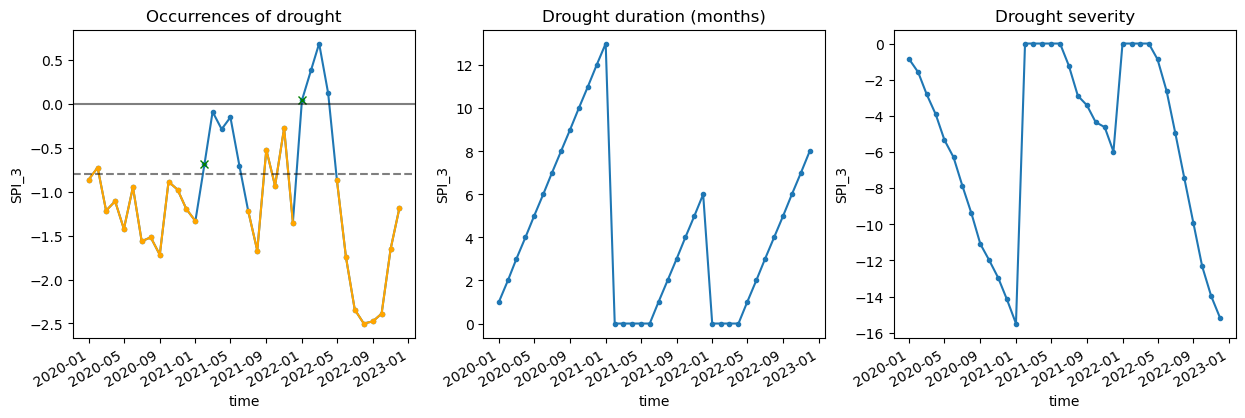

In [17]:
# time series plots for a single cell, to confirm that the calculation works

latlon = get_latlon("Buenos Aires, AR").values()
da = wrap_lon(xr.open_dataset("data/era5_spi3_monthly.nc").spi.rename(lat = "latitude", lon = "longitude").sel(time = slice("2020", None)))

fig, axs = plt.subplots(ncols = 3, dpi = 100, figsize = (15,4))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

ts = nearest_px(*latlon, da)
ts_lo = xr.ones_like(ts).where(rle(ts <= -0.8) > 0)                    # indicator for start of drought
ts_pos = xr.zeros_like(ts).where(rle(ts > -0.8) > 1)                   # indicator for start of non-drought
dm = xr.concat([ts_lo, ts_pos], "new").max("new").ffill("time")         # indicator for months during drought

ts.plot(ax = axs[0], marker = ".")
ts.where(ts_pos == 0).plot(ax = axs[0], color = "green", marker = "x")
ts.where(dm == 1).plot(ax = axs[0], color = "orange", marker = ".")

[axs[0].axhline(x, color = "k", ls = "--", alpha = 0.5) for x in [-0.8]]
[axs[0].axhline(x, color = "k", alpha = 0.5) for x in [0]]
axs[0].set_title("Occurrences of drought")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

run_cumsum(dm.where(dm == 1, 0)).plot(ax = axs[1], marker = ".")
axs[1].set_title("Drought duration (months)")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

run_cumsum(ts.where(dm == 1, 0)).plot(ax = axs[2], marker = ".")
axs[2].set_title("Drought severity")

---
### **Monthly maps of last three years**

#### **Precipitation**

In [15]:
for ens in ["cpc", "era5"]:
    
    da = xr.open_dataset("data/"+ens+"_precip_monthly.nc").sel(time = slice("2020-07", None)).precip
    
    nr = int(np.ceil(len(da.time) / 12))
    fig, axs = plt.subplots(ncols = 12, nrows = nr, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,(nr*2)+0.5))
    for ax in fig.axes[len(da.time):]: ax.set_axis_off()
    
    for i in range(len(da.time)):
        
        ax = fig.axes[i]
        cbar = da.isel(time = i).plot(ax = ax, add_colorbar = False, vmin = 0, vmax = 25, cmap = 'YlGnBu')
        xr.ones_like(da).where(da == 0).isel(time = i).plot(ax = ax, add_colorbar = False, cmap = "Oranges_r", vmin = 0, vmax = 1)      # overlay zero precip as white regions - reverse cmap to show in orange
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
        ax.set_title(da.time[i].dt.strftime("%Y-%m").values)
        
    plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "Daily precipitation rate (mm/day)", extend = "max")
    plt.suptitle(ens.upper()+" - mean monthly precipitation", fontweight = "bold")

    plt.savefig("fig/"+ens+"_pr_monthly.png"); plt.close()

#### **Temperature**

In [249]:
for ens in ["cpc", "era5"]:
    
    da = xr.open_dataset("data/"+ens+"_tas_monthly.nc").sel(time = slice("2020-07", None)).tas
    
    nr = int(np.ceil(len(da.time) / 12))
    fig, axs = plt.subplots(ncols = 12, nrows = nr, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,(nr*2)+0.5))
    for ax in fig.axes[len(da.time):]: ax.set_axis_off()
    
    for i in range(len(da.time)):
        
        ax = fig.axes[i]
        cbar = da.isel(time = i).plot(ax = ax, add_colorbar = False, vmax = 30, vmin = -10, cmap = "RdBu_r")
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
        ax.set_title(da.time[i].dt.strftime("%Y-%m").values)
        
    plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "Temperature (degC)", extend = "both")
    plt.suptitle(ens.upper()+" - monthly mean temperatures", fontweight = "bold")

    plt.savefig("fig/"+ens+"_tas_monthly.png"); plt.close()

#### **PET**

In [250]:
for ens in ["cpc", "era5"]:
    
    da = xr.open_dataset("data/"+ens+"_pet_monthly.nc").sel(time = slice("2020-07", None)).pet
    
    nr = int(np.ceil(len(da.time) / 12))
    fig, axs = plt.subplots(ncols = 12, nrows = nr, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,(nr*2)+0.5))
    for ax in fig.axes[len(da.time):]: ax.set_axis_off()
    
    for i in range(len(da.time)):
        
        ax = fig.axes[i]
        cbar = da.isel(time = i).plot(ax = ax, add_colorbar = False, vmin = 0, vmax = 6, cmap = "viridis")
        ax.coastlines()
        ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
        ax.set_title(da.time[i].dt.strftime("%Y-%m").values)
        
    plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "PET (mm/day)", extend = "max")
    plt.suptitle(ens.upper()+" - mean monthly PET rate (mm/day)", fontweight = "bold")

    plt.savefig("fig/"+ens+"_pet_monthly.png"); plt.close()

#### **Drought indices**

In [16]:
for ens in ["cpc", "era5"]:
    for varnm in ["spi", "spei"]:
        
        da = xr.open_dataset("data/"+ens+"_"+varnm+"3_monthly.nc").sel(time = slice("2020-07", None))[varnm]
        
        nr = int(np.ceil(len(da.time) / 12))
        fig, axs = plt.subplots(ncols = 12, nrows = nr, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,(nr*2)+0.5))
        for ax in fig.axes[len(da.time):]: ax.set_axis_off()
        
        for i in range(len(da.time)):
            
            ax = fig.axes[i]
            cbar = da.isel(time = i).plot(ax = ax, add_colorbar = False, vmin = -4, vmax = 4, cmap = "BrBG")
            ax.coastlines()
            ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
            ax.set_title(da.time[i].dt.strftime("%Y-%m").values)
        
        if varnm == "spi":
            plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "SPI_3", extend = "both")
            plt.suptitle(ens.upper()+" - 3-month standardised precipitation index", fontweight = "bold")
        else:
            plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "SPEI_3", extend = "both")
            plt.suptitle(ens.upper()+" - 3-month standardised precipitation-evapotranspiration index", fontweight = "bold")
        
        plt.savefig("fig/"+ens+"_"+varnm+"3_monthly.png"); plt.close()

#### **Drought classification**

In [238]:
drought_bins = [-np.inf, -2, -1.55, -1.25, -.75, -.5]

cmap = matplotlib.colors.ListedColormap(['darkred', 'red', 'orange', 'gold','yellow'])
cmap.set_over('honeydew')
bounds = np.arange(0.5,6.5,1)

for ens in ["cpc", "era5"]:
    for varnm in ["spi", "spei"]:
        
        da = xr.open_dataset("data/"+ens+"_"+varnm+"3_monthly.nc").sel(time = slice("2020-07", None))[varnm]
        da = xr.apply_ufunc(np.digitize, da, kwargs={'bins': bins}).where(~np.isnan(da))
        # da = da.where(da < 6)
        
        nr = int(np.ceil(len(da.time) / 12))
        fig, axs = plt.subplots(ncols = 12, nrows = nr, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,(nr*2)+0.5))
        for ax in fig.axes[len(da.time):]: ax.set_axis_off()
        
        for i in range(len(da.time)):
            
            ax = fig.axes[i]
            cbar = da.isel(time = i).plot(ax = ax, add_colorbar = False, cmap = cmap, norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N))
            ax.coastlines()
            ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
            ax.set_title(da.time[i].dt.strftime("%Y-%m").values)
        
        cbar = plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, ticks=list(range(1,6)), extend = "max", label = "Drought classification")
        cbar.ax.set_xticklabels(["D" + str(x) for x in range(4,-1,-1)])
        
        plt.suptitle(ens.upper()+" - drought classifications using 3-month "+varnm.upper(), fontweight = "bold")
        
        plt.savefig("fig/"+ens+"_"+varnm+"3-classification_monthly.png"); plt.close()

#### **Drought severity**

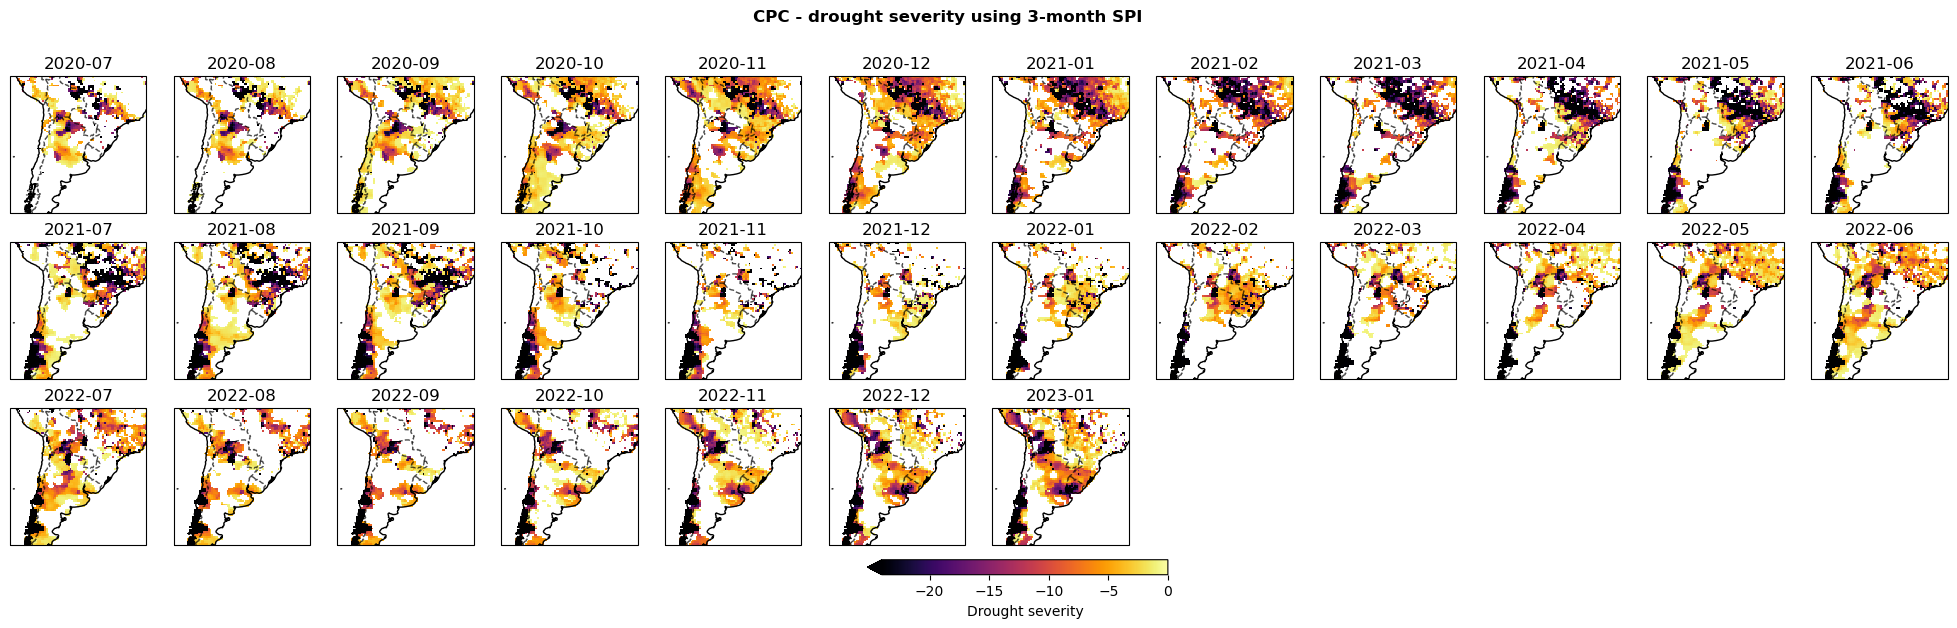

In [19]:
for ens in ["cpc", "era5"][:1]:
    for varnm in ["spi", "spei"][:1]:
        
        da = xr.open_dataset("data/"+ens+"_"+varnm+"3-drought-severity.nc").sel(time = slice("2020-07", None)).drought_severity
        
        nr = int(np.ceil(len(da.time) / 12))
        fig, axs = plt.subplots(ncols = 12, nrows = nr, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,(nr*2)+0.5))
        for ax in fig.axes[len(da.time):]: ax.set_axis_off()
        
        for i in range(len(da.time)):
            
            ax = fig.axes[i]
            cbar = da.isel(time = i).where(da.isel(time = i) < 0).plot(ax = ax, add_colorbar = False, vmax = 0, vmin = -50, cmap = "inferno")
            ax.coastlines()
            ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
            ax.set_title(da.time[i].dt.strftime("%Y-%m").values)
        
        plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "Drought severity", extend = "min")
        plt.suptitle(ens.upper()+" - drought severity using 3-month "+varnm.upper(), fontweight = "bold")
        
        plt.savefig("fig/"+ens+"_"+varnm+"3-severity_monthly.png"); plt.close()

#### **Drought duration**

In [239]:
for ens in ["cpc", "era5"]:
    for varnm in ["spi", "spei"]:
        
        da = xr.open_dataset("data/"+ens+"_"+varnm+"3-drought-duration.nc").sel(time = slice("2020-07", None)).drought_duration
        
        nr = int(np.ceil(len(da.time) / 12))
        fig, axs = plt.subplots(ncols = 12, nrows = nr, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,(nr*2)+0.5))
        for ax in fig.axes[len(da.time):]: ax.set_axis_off()
        
        for i in range(len(da.time)):
            
            ax = fig.axes[i]
            cbar = da.isel(time = i).where(da.isel(time = i) > 0).plot(ax = ax, add_colorbar = False, vmin = 0, vmax = 12, cmap = "Oranges")
            ax.coastlines()
            ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
            ax.set_title(da.time[i].dt.strftime("%Y-%m").values)
        
        plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "Drought duration (months)", extend = "max")
        plt.suptitle(ens.upper()+" - drought duration using 3-month "+varnm.upper(), fontweight = "bold")
        
        plt.savefig("fig/"+ens+"_"+varnm+"3-duration_monthly.png"); plt.close()

---
### **Compare R fitting vs python**

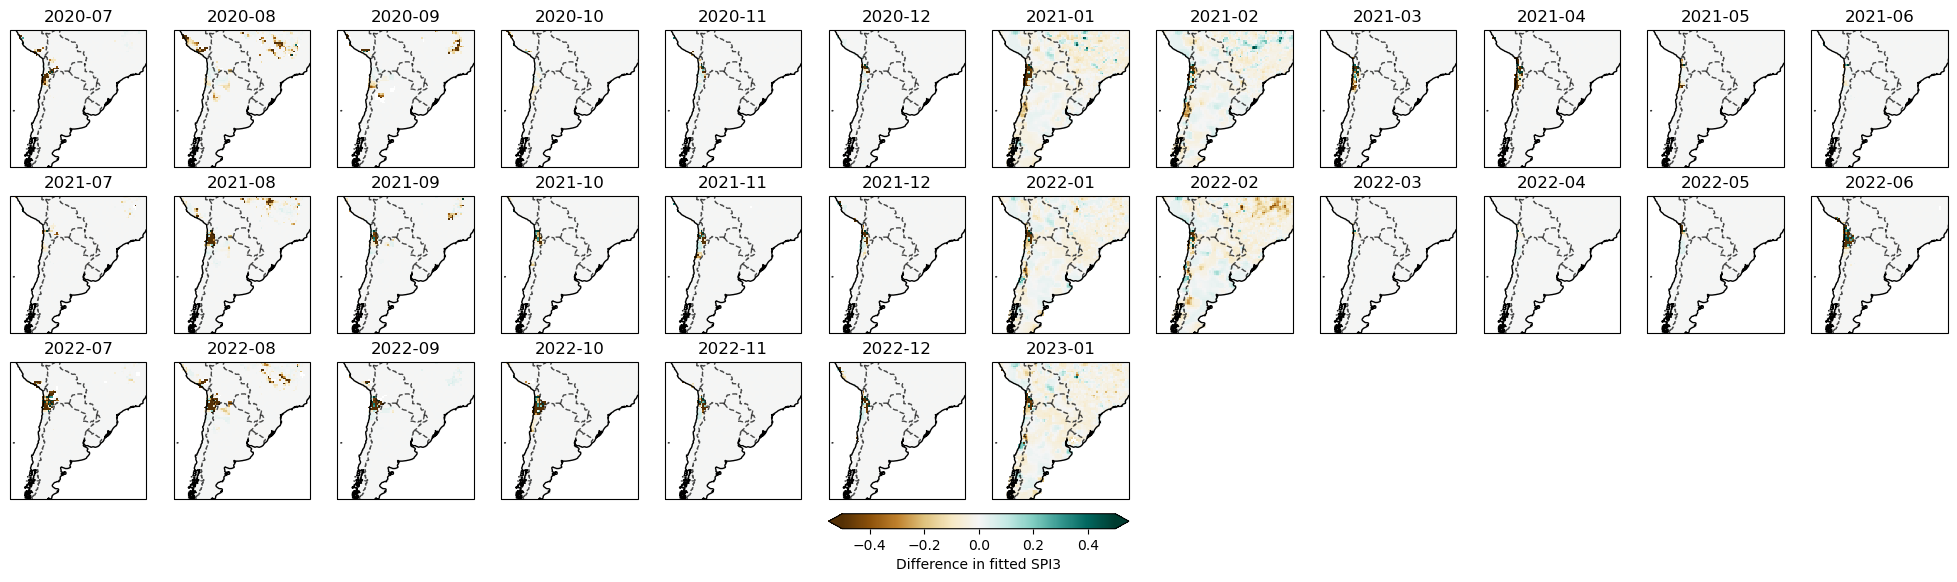

In [110]:
# load values fitted using script above
da_py = xr.open_dataset("data/cpc_spi3_monthly.nc").spi

# load & reshape values fitted using R SPEI package
df = pd.read_csv("data/cpc_spi3_rfitted.csv", index_col = "time").dropna(axis = 0, how = "all")
da_r = xr.DataArray(data = np.array(df).reshape(da_py.transpose("time", ...).shape),
                    dims = {"time" : da_py.time, "lat" : da_py.lat, "lon" : da_py.lon},
                    coords = {"time" : da_py.time, "lat" : da_py.lat, "lon" : da_py.lon})

da = (da_py - da_r).sel(time = slice("2020-07", None))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

nr = int(np.ceil(len(da.time) / 12))
fig, axs = plt.subplots(ncols = 12, nrows = nr, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, figsize = (25,(nr*2)+0.5))
for ax in fig.axes[len(da.time):]: ax.set_axis_off()

for i in range(len(da.time)):
    
    ax = fig.axes[i]
    cbar = da.isel(time = i).plot(ax = ax, add_colorbar = False, cmap = "BrBG", vmin = -0.5, vmax = 0.5)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.7)
    ax.set_title(da.time[i].dt.strftime("%Y-%m").values)
    
plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.03, pad = 0.03, label = "Difference in fitted SPI3", extend = "both")

# Atacama desert very different, probably due to presence of large number of zeros in the data. Ditto scattered cells in Brazil.
# slightly larger differences in Jan/Feb (again, this is the dry season, so probably unsurprising)

## **Define spatial region**

### **Build shapefile & extract boundary, points**
Administrative shapefiles downloaded from https://data.humdata.org

In [9]:
# create a single shapefile containing the selected regions

sf_ar = gpd.read_file("sf/AR_adm1").to_crs(cartopy.crs.PlateCarree()).set_index("ADM1_PCODE")
sf_ar = sf_ar[sf_ar.geometry.centroid.y > -36.7]
sf_br = gpd.read_file("sf/BR_adm1").set_crs(cartopy.crs.PlateCarree()).set_index("ADM1_PCODE")
sf_br = sf_br[sf_br.geometry.centroid.y < -24.5]
sf_uy = gpd.read_file("sf/UY_adm0").to_crs(cartopy.crs.PlateCarree()).set_index("ADM0_PCODE")
sf_bo = gpd.read_file("sf/BO_adm1").to_crs(cartopy.crs.PlateCarree()).set_index("ADM1_PCODE")

sf = pd.concat([sf_ar[sf_ar.geometry.centroid.y > -36.7], sf_br[sf_br.geometry.centroid.y < -24.5], sf_uy, sf_bo.loc[["BO06", "BO01"]]])
sf.to_file("sf/provinces")

sf = sf.dissolve().explode(index_parts = False)
sf["geometry"] = sf.geometry.apply(lambda p: Polygon(list(p.exterior.coords)))

In [10]:
gp = xr.open_dataset("../90_data/era5_geopotential-0.25.nc").squeeze(drop = True).z.sel(latitude = slice(-10,-50), longitude = slice(280,320))

# create mask from shapefile
rm = regionmask.mask_3D_geopandas(sf, gp.longitude, gp.latitude).sum("region")

# find areas within Argentina with geopotential < 20000
rm = rm.where(rm).where(gp < 20000).dropna("latitude", "all").dropna("longitude", "all")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## CONVERT REGIONMASK BACK INTO TO POLYGON

# define affine transform to correct coordinates
res = 0.25
transform = np.array([res,0,rm.longitude.min().values - res/2,0,-res,rm.latitude.max().values + res/2])

# convert xarray data to polygon, remove any interior holes, select single largest polygon & smooth edges
rm_poly = polygonize(rm, mask = rm == 1, return_type = "geopandas", transform = transform).set_crs(epsg = "4326")
rm_poly["geometry"] = rm_poly.geometry.apply(lambda p: Polygon(list(p.exterior.coords)))
rm_poly = rm_poly[rm_poly.geometry.area == rm_poly.geometry.area.max()]
rm_poly = rm_poly.simplify(0.25)

# save as shapefile
rm_poly.to_file("sf_CSA-drought")

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
## EXTRACT POINTS FROM POLYGON

rm_px = rm_poly.apply(lambda p: list(p.exterior.coords)).explode().apply(pd.Series).rename(columns=({0:"x", 1:"y"}))
rm_px["x"] = rm_px.x - 360

# save list of points for upload to climate explorer
rm_px.to_csv("sf_CSA-drought.txt", sep = " ", index = False)

/tmp/ipykernel_40511/3172607388.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  rm_poly = rm_poly[rm_poly.geometry.area == rm_poly.geometry.area.max()]


#### **Check shapefile**

In [11]:
sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())
px = pd.read_csv("sf_CSA-drought.txt", sep = " ")
gp = xr.open_dataset("../90_data/era5_geopotential-0.25.nc").squeeze(drop = True).z.sel(latitude = slice(-10,-50), longitude = slice(280,320))

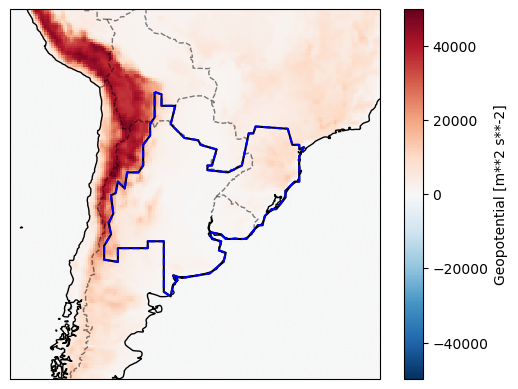

In [12]:
fig, ax = plt.subplots(ncols = 1, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100)
gp.plot(ax = ax)
sf.boundary.plot(ax = ax, color = "k")
ax.plot(px.x, px.y, color = "blue", ls = "--")
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5, )

## **Event maps**

Latest data downloaded Jan 17th: up to & including Jan 11th for both CPC and ERA5.

### **Drought classification**

In [7]:
# load station data
obs = pd.read_csv("station-timeseries.csv", index_col = "fecha", parse_dates = True)[[str(s) for s in [83967, 87047, 87078, 87129, 87345, 87480, 87509, 87585, 87641]]].resample("MS").mean()
gdf = pd.read_csv("station-data.csv", index_col ="omm_id").loc[[int(c) for c in obs.columns]]

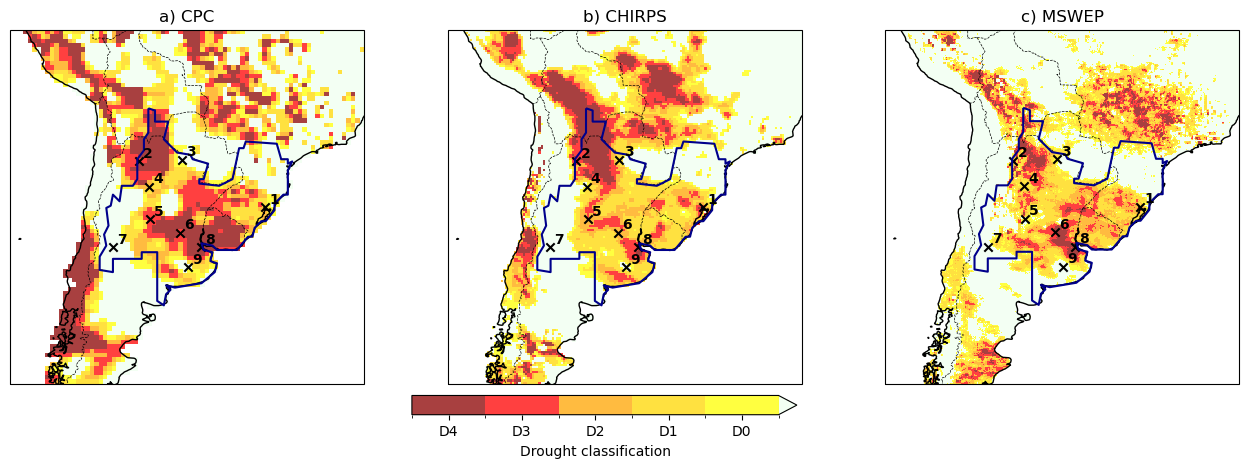

In [25]:
event_date = "2022-12"

# load latest data, discretize to get drought classifications
cpc = xr.open_dataset("data/cpc_spi3_monthly.nc").spi.sel(time = event_date)
era5 = xr.open_dataset("data/era5_spi3_monthly.nc").spi.sel(time = event_date)
chirps = xr.open_dataset("data/chirps_spi3_monthly.nc").spi.sel(time = event_date)
mswep = xr.open_dataset("data/mswep_spi3_monthly.nc").spi.sel(time = event_date)

cpc, era5, chirps, mswep = [xr.apply_ufunc(np.digitize, da, kwargs={'bins': [-np.inf, -2, -1.55, -1.25, -.75, -.5]}).where(~np.isnan(da)) for da in [cpc, era5, chirps, mswep]]

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())
provinces = gpd.read_file("sf/provinces").set_crs(cartopy.crs.PlateCarree())

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

cmap = matplotlib.colors.ListedColormap(['darkred', 'red', 'orange', 'gold','yellow']); cmap.set_over('honeydew')
cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.07, "shrink" : 0.85, "label" : "Drought classification", "ticks" : list(range(1,6))}
plot_kwargs = {"cmap" : cmap, "norm" : matplotlib.colors.BoundaryNorm(np.arange(0.5,6.5,1), cmap.N), "add_colorbar" : False, "alpha" : 0.75}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fig, axs = plt.subplots(ncols = 3, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100, figsize = (16,5))

cbar = cpc.plot(ax = axs[0], **plot_kwargs); axs[0].set_title("a) CPC")
chirps.plot(ax = axs[1], **plot_kwargs); axs[1].set_title("b) CHIRPS")
mswep.plot(ax = axs[2], **plot_kwargs); axs[2].set_title("c) MSWEP")

for ax in axs:
    sf.boundary.plot(ax = ax, color = "darkblue", lw = 1.5)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 1, lw = 0.5)
    # ax.add_feature(cartopy.feature.RIVERS, color = "darkblue")
    # provinces.boundary.plot(ax = ax, color = "k", ls = "--", alpha = 0.5, lw = 0.5)
    
    for i in range(9):
        ax.scatter(gdf.iloc[i].longitud, gdf.iloc[i].latitud, marker = "x", color = "k")
        ax.annotate(str(i+1), xy = [gdf.iloc[i].longitud, gdf.iloc[i].latitud], textcoords="offset points", xytext=(3,3), ha = 'left', fontweight = "bold")
        # [ax.annotate(str(k), xy = [v.longitud, v.latitud], textcoords="offset points", xytext=(5,3), ha = 'left', fontweight = "bold") for k,v in gdf.iterrows()]
    
cbar = plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.03, ticks=list(range(1,6)), extend = "max", label = "Drought classification")
cbar.ax.set_xticklabels(["D" + str(x) for x in range(4,-1,-1)])
    
# plt.suptitle("Drought classification in December 2022 based on 3-month SPI", fontweight = "bold")

plt.savefig("fig/event-map_spi3_dec22.png")

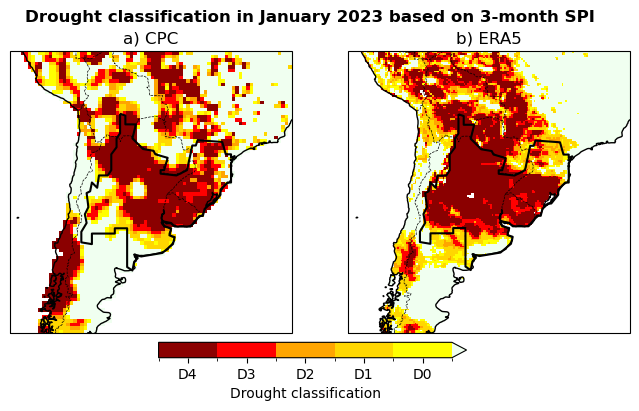

In [46]:
event_date = "2023-01"

# load latest data, discretize to get drought classifications
cpc = xr.open_dataset("data/cpc_spi3_monthly.nc").spi.sel(time = event_date)
era5 = xr.open_dataset("data/era5_spi3_monthly.nc").spi.sel(time = event_date)

cpc, era5 = [xr.apply_ufunc(np.digitize, da, kwargs={'bins': [-np.inf, -2, -1.55, -1.25, -.75, -.5]}).where(~np.isnan(da)) for da in [cpc, era5]]

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())
provinces = gpd.read_file("sf/provinces").set_crs(cartopy.crs.PlateCarree())

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

cmap = matplotlib.colors.ListedColormap(['darkred', 'red', 'orange', 'gold','yellow']); cmap.set_over('honeydew')
cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.07, "shrink" : 0.85, "label" : "Drought classification", "ticks" : list(range(1,6))}
plot_kwargs = {"cmap" : cmap, "norm" : matplotlib.colors.BoundaryNorm(np.arange(0.5,6.5,1), cmap.N), "add_colorbar" : False}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fig, axs = plt.subplots(ncols = 2, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100, figsize = (8,4))

cbar = cpc.plot(ax = axs[0], **plot_kwargs); axs[0].set_title("a) CPC")
era5.plot(ax = axs[1], **plot_kwargs); axs[1].set_title("b) ERA5")

for ax in axs:
    sf.boundary.plot(ax = ax, color = "k", lw = 1.5)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 1, lw = 0.5)
    # ax.add_feature(cartopy.feature.RIVERS, color = "darkblue")
    # provinces.boundary.plot(ax = ax, color = "k", ls = "--", alpha = 0.5, lw = 0.5)
    
cbar = plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.03, ticks=list(range(1,6)), extend = "max", label = "Drought classification")
cbar.ax.set_xticklabels(["D" + str(x) for x in range(4,-1,-1)])
    
plt.suptitle("Drought classification in January 2023 based on 3-month SPI", fontweight = "bold")

plt.savefig("fig/event-map_spi3_jan23.png")

### **Absolute precipitation**

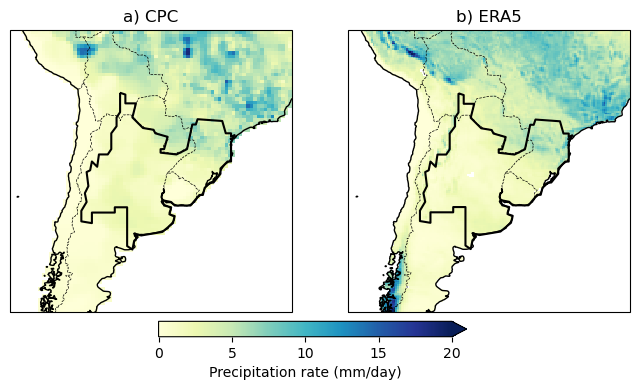

In [65]:
event_date = "2023-01"

# load latest data
cpc = xr.open_dataset("data/cpc_precip_monthly.nc").precip.rolling(time = 4).mean().sel(time = event_date)
era5 = xr.open_dataset("data/era5_precip_monthly.nc").precip.rolling(time = 4).mean().sel(time = event_date)

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())
provinces = gpd.read_file("sf/provinces").set_crs(cartopy.crs.PlateCarree())

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

plot_kwargs = {"cmap" : "YlGnBu", "vmin" : 0, "vmax" : 20, "add_colorbar" : False}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fig, axs = plt.subplots(ncols = 2, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100, figsize = (8,4))

cbar = cpc.plot(ax = axs[0], **plot_kwargs); axs[0].set_title("a) CPC")
era5.plot(ax = axs[1], **plot_kwargs); axs[1].set_title("b) ERA5")

for ax in axs:
    sf.boundary.plot(ax = ax, color = "k", lw = 1.5)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 1, lw = 0.5)
    # ax.add_feature(cartopy.feature.RIVERS, color = "darkblue")
    # provinces.boundary.plot(ax = ax, color = "k", ls = "--", alpha = 0.5, lw = 0.5)
    
cbar = plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.03, extend = "max", label = "Precipitation rate (mm/day)")
    
# plt.suptitle("Mean precipitation rate from November 1st 2022 - January 11th 2023", fontweight = "bold")

plt.savefig("fig/event-map_pr-ondj_jan23.png")

### **Absolute precipitation anomaly**

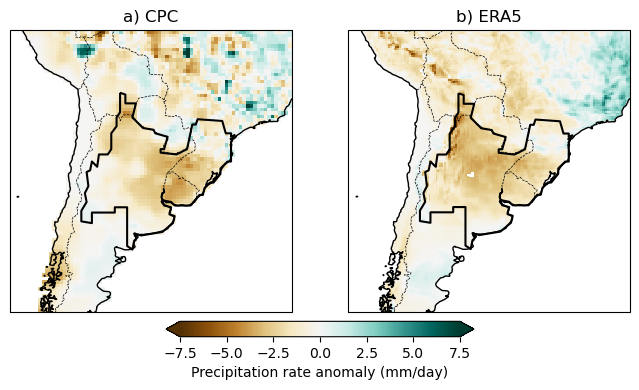

In [85]:
event_date = "2023-01"

# load latest data
cpc = xr.open_dataset("data/cpc_precip_monthly.nc").precip.rolling(time = 4).mean().groupby("time.month")[1]
era5 = xr.open_dataset("data/era5_precip_monthly.nc").precip.rolling(time = 4).mean().groupby("time.month")[1]

cpc, era5 = [(da.sel(time = "2023") - da.sel(time = slice("1980", "2022")).mean("time")) for da in [cpc, era5]]

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())
provinces = gpd.read_file("sf/provinces").set_crs(cartopy.crs.PlateCarree())

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

plot_kwargs = {"cmap" : "BrBG", "vmin" : -7.5, "vmax" : 7.5, "add_colorbar" : False}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

fig, axs = plt.subplots(ncols = 2, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100, figsize = (8,4))

cbar = cpc.plot(ax = axs[0], **plot_kwargs); axs[0].set_title("a) CPC")
era5.plot(ax = axs[1], **plot_kwargs); axs[1].set_title("b) ERA5")

for ax in axs:
    sf.boundary.plot(ax = ax, color = "k", lw = 1.5)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 1, lw = 0.5)
    # ax.add_feature(cartopy.feature.RIVERS, color = "darkblue")
    # provinces.boundary.plot(ax = ax, color = "k", ls = "--", alpha = 0.5, lw = 0.5)
    
cbar = plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.03, extend = "both", label = "Precipitation rate anomaly (mm/day)")
    
# plt.suptitle("Anomaly in mean precipitation rate from November 1st 2022 - January 11th 2023\n wrt climatology 1980-2010", fontweight = "bold")

plt.savefig("fig/event-map_pr-anom-ondj_jan23.png")

## **Observational analysis (reanalysis)**

### **Daily time series of mean precip in study region**

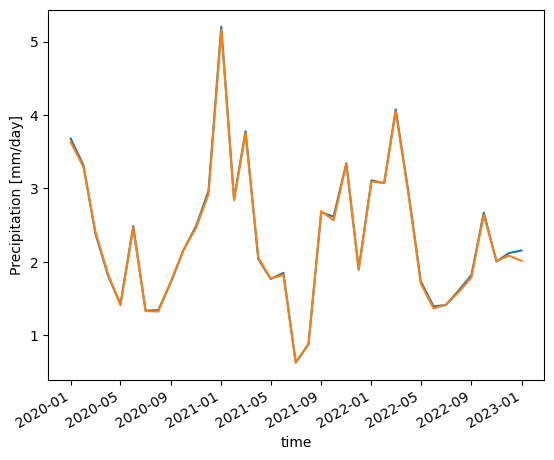

In [54]:
# quick check that ERA5 data downloaded from Climate Explorer is correctly masked
era5_m = xr.open_dataset("data/era5_precip_monthly.nc").precip
sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())
rm = regionmask.mask_3D_geopandas(sf, era5_m.lon, era5_m.lat).squeeze(drop = True)
era5_m = era5_m.where(rm == 1).mean(["lat", "lon"])

era5 = xr.open_dataset("data/iera5_prcp_daily_e_mask25_5lan_su.nc").tp.sel(time = slice(None, "2023-01-11")) # remove forecast days
era5.rename("precip").to_netcdf("data/era5_CSA_daily.nc")
era5.resample(time = "MS").mean().sel(time = slice("2020", None)).plot()

era5_m.sel(time = slice("2020", None)).plot()

In [3]:
# extract daily time series of mean over study region
cpc = xr.open_mfdataset("../../Data/cpc/precip.*.nc").sel(lat = slice(-10,-50), lon = slice(280,320)).precip
sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())
rm = regionmask.mask_3D_geopandas(sf, cpc.lon, cpc.lat).squeeze(drop = True)
cpc = cpc.where(rm).mean(["lat", "lon"])
cpc.to_netcdf("data/cpc_CSA_daily.nc")

### **Spatial patterns**

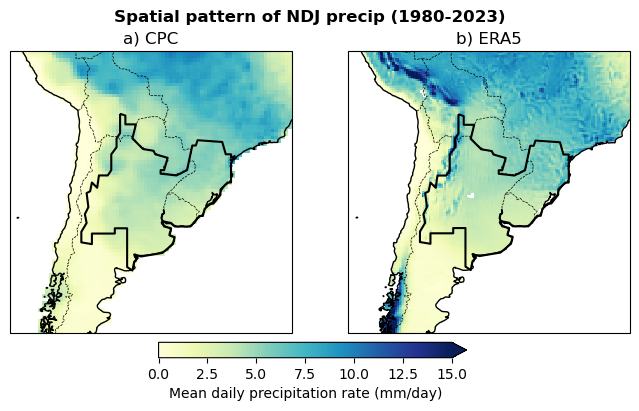

In [116]:
# spatial patterns of NDJ precip from 1980-present

cpc = xr.open_dataset("data/cpc_precip_monthly.nc").precip.rolling(time = 3).mean().groupby("time.month")[1].dropna("time", "all").sel(time = slice("1980", None)).mean("time")
era5 = xr.open_dataset("data/era5_precip_monthly.nc").precip.rolling(time = 3).mean().groupby("time.month")[1].dropna("time", "all").sel(time = slice("1980", None)).mean("time")

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

fig, axs = plt.subplots(ncols = 2, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100, figsize = (8,4))

plot_kwargs = {"cmap" : "YlGnBu", "vmin" : 0, "vmax" : 15, "add_colorbar" : False}

cbar = cpc.plot(ax = axs[0], **plot_kwargs); axs[0].set_title("a) CPC")
era5.plot(ax = axs[1], **plot_kwargs); axs[1].set_title("b) ERA5")

# plt.gcf().axes[-1].set_xticklabels(["D" + str(x) for x in range(4,-1,-1)])

for ax in axs:
    sf.boundary.plot(ax = ax, color = "k", lw = 1.5)
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 1, lw = 0.5)
    
cbar = plt.colorbar(cbar, ax = axs, location = "bottom", fraction = 0.05, pad = 0.03, extend = "max", label = "Mean daily precipitation rate (mm/day)")
# cbar.ax.set_xticklabels(["D" + str(x) for x in range(4,-1,-1)])
    
plt.suptitle("Spatial pattern of NDJ precip (1980-2023)", fontweight = "bold")

plt.savefig("fig/spatial_pr-NDJ_obs.png")

### **Seasonal cycle**

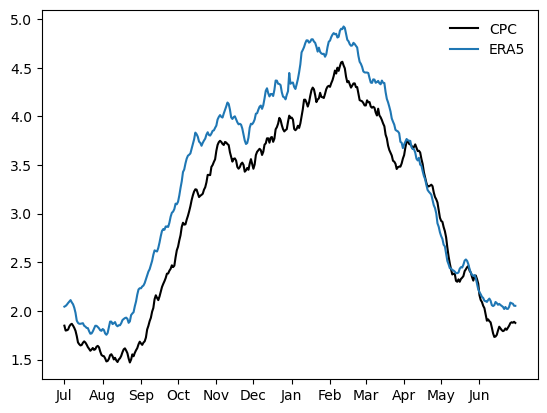

In [35]:
era5 = xr.open_dataset("data/era5_CSA_daily.nc").precip
cpc = xr.open_dataset("data/cpc_CSA_daily.nc").precip

y_offset = 365-era5.sel(time = "2020-07-01").time.dt.dayofyear

era5_sc = era5.rolling(time = 15).mean().groupby("time.dayofyear").mean()
era5_sc = era5_sc.reindex(dayofyear = era5_sc.dayofyear.sortby((era5_sc.dayofyear + y_offset) % 366))

cpc_sc = cpc.rolling(time = 15).mean().groupby("time.dayofyear").mean()
cpc_sc = cpc_sc.reindex(dayofyear = cpc_sc.dayofyear.sortby((cpc_sc.dayofyear + y_offset) % 366))

plt.plot(cpc_sc, color = "k", label = "CPC")
plt.plot(era5_sc, color = "tab:blue", label = "ERA5")

sc_xlabels(era5.sel(time = slice("2019-07-01", "2020-06-30")).time, ax = plt.gcf().axes[0])
plt.legend(edgecolor = "w")

plt.axvline()

### **3-month or 4-month precip?**

In [149]:
reanalysis = {ens : xr.open_dataset("data/"+ens+"_CSA_daily.nc").precip.resample(time = "MS").mean() for ens in ["era5", "cpc", "chirps"]}

fig, axs = plt.subplots(ncols = 3, figsize = (16,3), sharey = True)

for i in range(3):
    
    ens = list(reanalysis.values())[i]
    
    ens.rolling(time = 3).mean().groupby("time.month")[1].plot(ax = axs[i], label = "NDJ")
    ens.rolling(time = 4).mean().groupby("time.month")[1].plot(ax = axs[i], label = "ONDJ")
    ens.rolling(time = 3).mean().groupby("time.month")[12].plot(ax = axs[i], label = "OND")
    
    axs[i].set_title(list(reanalysis.keys())[i])
    axs[i].legend()

plt.savefig("ndj-ondj_timeseries.png")

### **Use SPI or precip?**

In [94]:
pr_ond = pd.read_csv("ts/CSA-drought_pr-ond_chirps.dat", comment = "#", sep = " ", header = None, names = ["year", "pr"], index_col = "year")
spi_ond = pd.read_csv("ts/CSA-drought_spi-ond_chirps.dat", comment = "#", sep = " ", header = None, names = ["year", "spi"], index_col = "year")

fig, axs = plt.subplots(ncols = 2, figsize = (12,4), sharey = True, sharex = True)
plt.subplots_adjust(wspace = 0)

axs[0].step(pr_ond.index, pr_ond, label = "Precip")
axs[0].step(spi_ond.index, spi_ond, label = "SPI")
axs[0].set_title("3-month precip & SPI")
axs[0].legend(edgecolor = "w")

axs[1].step(pr_ond.index, (pr_ond - pr_ond.mean()) / pr_ond.std(), label = "Shifted, scaled precip")
axs[1].step(spi_ond.index, spi_ond, label = "SPI")
axs[1].set_title("Normalised 3-month precip & SPI")
axs[1].legend(edgecolor = "w")

for ax in axs: ax.axhline(0, color = "k", lw = 1, alpha = 0.5)

plt.savefig("spi3-pr3-timeseries.png")

### **Time series for climate explorer**

In [143]:
for ens in ["cpc", "era5", "chirps"]:
        
    csv_fnm = "ts/CSA-drought_pr-ndj_"+ens+".dat"
    
    # create extra header lines for upload to Climate Explorer
    str1 = "# contact :: "+ens+" NDJ precip central South America drought (up to Jan 11) 2023, c.barnes22@imperial.ac.uk"
    str2 = "# precip [mm/day] NDJ mean precipitation rate at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year precip"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    da = xr.open_dataset("data/"+ens+"_CSA_daily.nc").precip
    da_ndj = da.resample(time = "MS").mean().rolling(time = 3).mean().groupby("time.month")[1].dropna("time", "any")
    da_ndj = da_ndj.assign_coords(time = da_ndj.time.dt.year)

    da_ndj.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

## **Station data**

### **Select stations with most complete data**

In [65]:
# load station locations; filter stations to include only those inside the study region
stn = pd.read_csv("stations/metadatos.csv", index_col = "omm_id")

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())
stn_gdf = gpd.GeoDataFrame(stn, geometry= gpd.points_from_xy(stn.longitud, stn.latitud), crs = cartopy.crs.PlateCarree())
stn_gdf = gpd.sjoin(stn_gdf, sf, predicate='within')

In [66]:
# load station data, filter to remove data prior to 1961, which is very patchy
df = reduce(lambda left, right: pd.merge(left,right,left_index = True, right_index = True, how = 'outer'), 
                   [pd.read_csv(fnm, sep = "\t", index_col = "fecha")[["prcp"]].rename(columns = {"prcp" : fnm[9:14]}) for fnm in glob.glob("stations/*.txt")]).loc[slice("1961-07-01", None)]
df.index = pd.to_datetime(df.index)

# filter out points outside the study region
df = df.loc[:,[int(c) in stn_gdf.index for c in df.columns]]

In [67]:
# filter out points with missing data Oct-Dec
df = df.loc[:,df.loc[slice("2022-10", "2022-12-25")].count(axis = 0) >= 86]
stn_gdf_22 = stn_gdf.loc[[int(c) for c in df.columns]]

# select only stations with relatively complete records for OND period (excluding this year, which was already checked) - 32 stations remain
df_complete = df.loc[:,df.loc[[m in [10,11,12] for m in df.index.month]].loc[slice(None, "2022-06-30")].resample("AS-JUL").count().min(0) > 90].copy()
df_complete["87480"] = df["87480"] # keep Rosario: only one year with missing data, third largest city
stn_gdf_complete = stn_gdf.loc[[int(c) for c in df_complete.columns]].sort_values(by = "latitud", ascending = False)

df_complete.to_csv("station-timeseries.csv")
stn_gdf_complete[["nombre", "latitud", "longitud", "elevacion", "nivel_adm1"]].to_csv("station-data.csv")

In [96]:
# compute OND precip & save for analysis in R
df_ond = df_complete.loc[[m in [10,11,12] for m in df_complete.index.month]].resample("AS-JUL").mean()

df_ond.index = df_ond.index.year
df_ond.loc[1962, ["87480"]] = np.nan # Rosario: missing data in this year
df_ond.to_csv("stations/station-ond.csv")

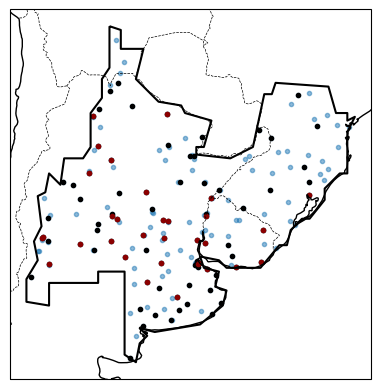

In [60]:
fig, ax = plt.subplots(ncols = 1, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100)
ax.scatter(stn_gdf.longitud, stn_gdf.latitud, marker = ".", alpha = 0.5)
ax.scatter(stn_gdf_22.longitud, stn_gdf_22.latitud, marker = ".", color = "k")
ax.scatter(stn_gdf_complete.longitud, stn_gdf_complete.latitud, marker = ".", color = "darkred")

sf.boundary.plot(ax = ax, color = "k", lw = 1.5)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 1, lw = 0.5)

[87047, 87078, 83067, 87059, 87585, 87679]

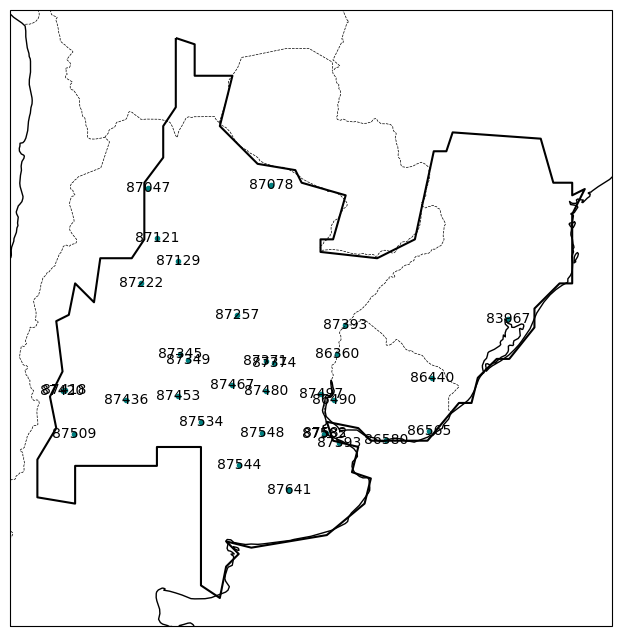

In [63]:
# identify individual stations
fig, ax = plt.subplots(ncols = 1, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100, figsize = (8,8))
ax.scatter(stn_gdf_complete.longitud, stn_gdf_complete.latitud, marker = ".", color = "teal")

[ax.annotate(str(k), xy = [v.longitud, v.latitud], ha = "center", va = "center") for k,v in stn_gdf_complete.iterrows()]

sf.boundary.plot(ax = ax, color = "k", lw = 1.5)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 1, lw = 0.5)

[87047, 87078, 83067, 87059, 87585, 87679]
# will leave duplicates in for validation

### **Compare station data with reanalysis**

#### **Extract monthly time series closest to each point**

In [3]:
gdf = pd.read_csv("station-data.csv", index_col = "omm_id")

In [4]:
for ds in ["cpc", "chirps", "mswep", "era5"]:
    da = wrap_lon(xr.open_dataset("data/"+ds+"_precip_monthly.nc").precip)
    ts = xr.concat([nearest_px(v.longitud, v.latitud, da, xcoord = "lon", ycoord = "lat").expand_dims(stn = [k]) for k,v in gdf.iterrows()], "stn")
    
    ts = ts.sel(time = [m in [10,11,12] for m in ts.time.dt.month]).resample(time = "AS-JUL").mean()
    ts.transpose().to_pandas().to_csv("stations/"+ds+"station-ond.csv")

#### **OND mean precipitation**

In [1]:
gdf = pd.read_csv("station-data.csv", index_col ="omm_id")
obs = pd.read_csv("stations/stations_daily_obs.csv", index_col = "fecha", parse_dates = True)

cpc = pd.read_csv("stations/stations_monthly_cpc.csv", index_col = "time", parse_dates = True)
chirps = pd.read_csv("stations/stations_monthly_chirps.csv", index_col = "time", parse_dates = True)
mswep = pd.read_csv("stations/stations_monthly_mswep.csv", index_col = "time", parse_dates = True)

# get ONDJ mean precip
obs, era5, cpc, chirps, mswep = [df.loc[[m in [10,11,12] for m in df.index.month]].resample("AS-JUL").mean() for df in [obs, era5, cpc, chirps, mswep]]

NameError: name 'pd' is not defined

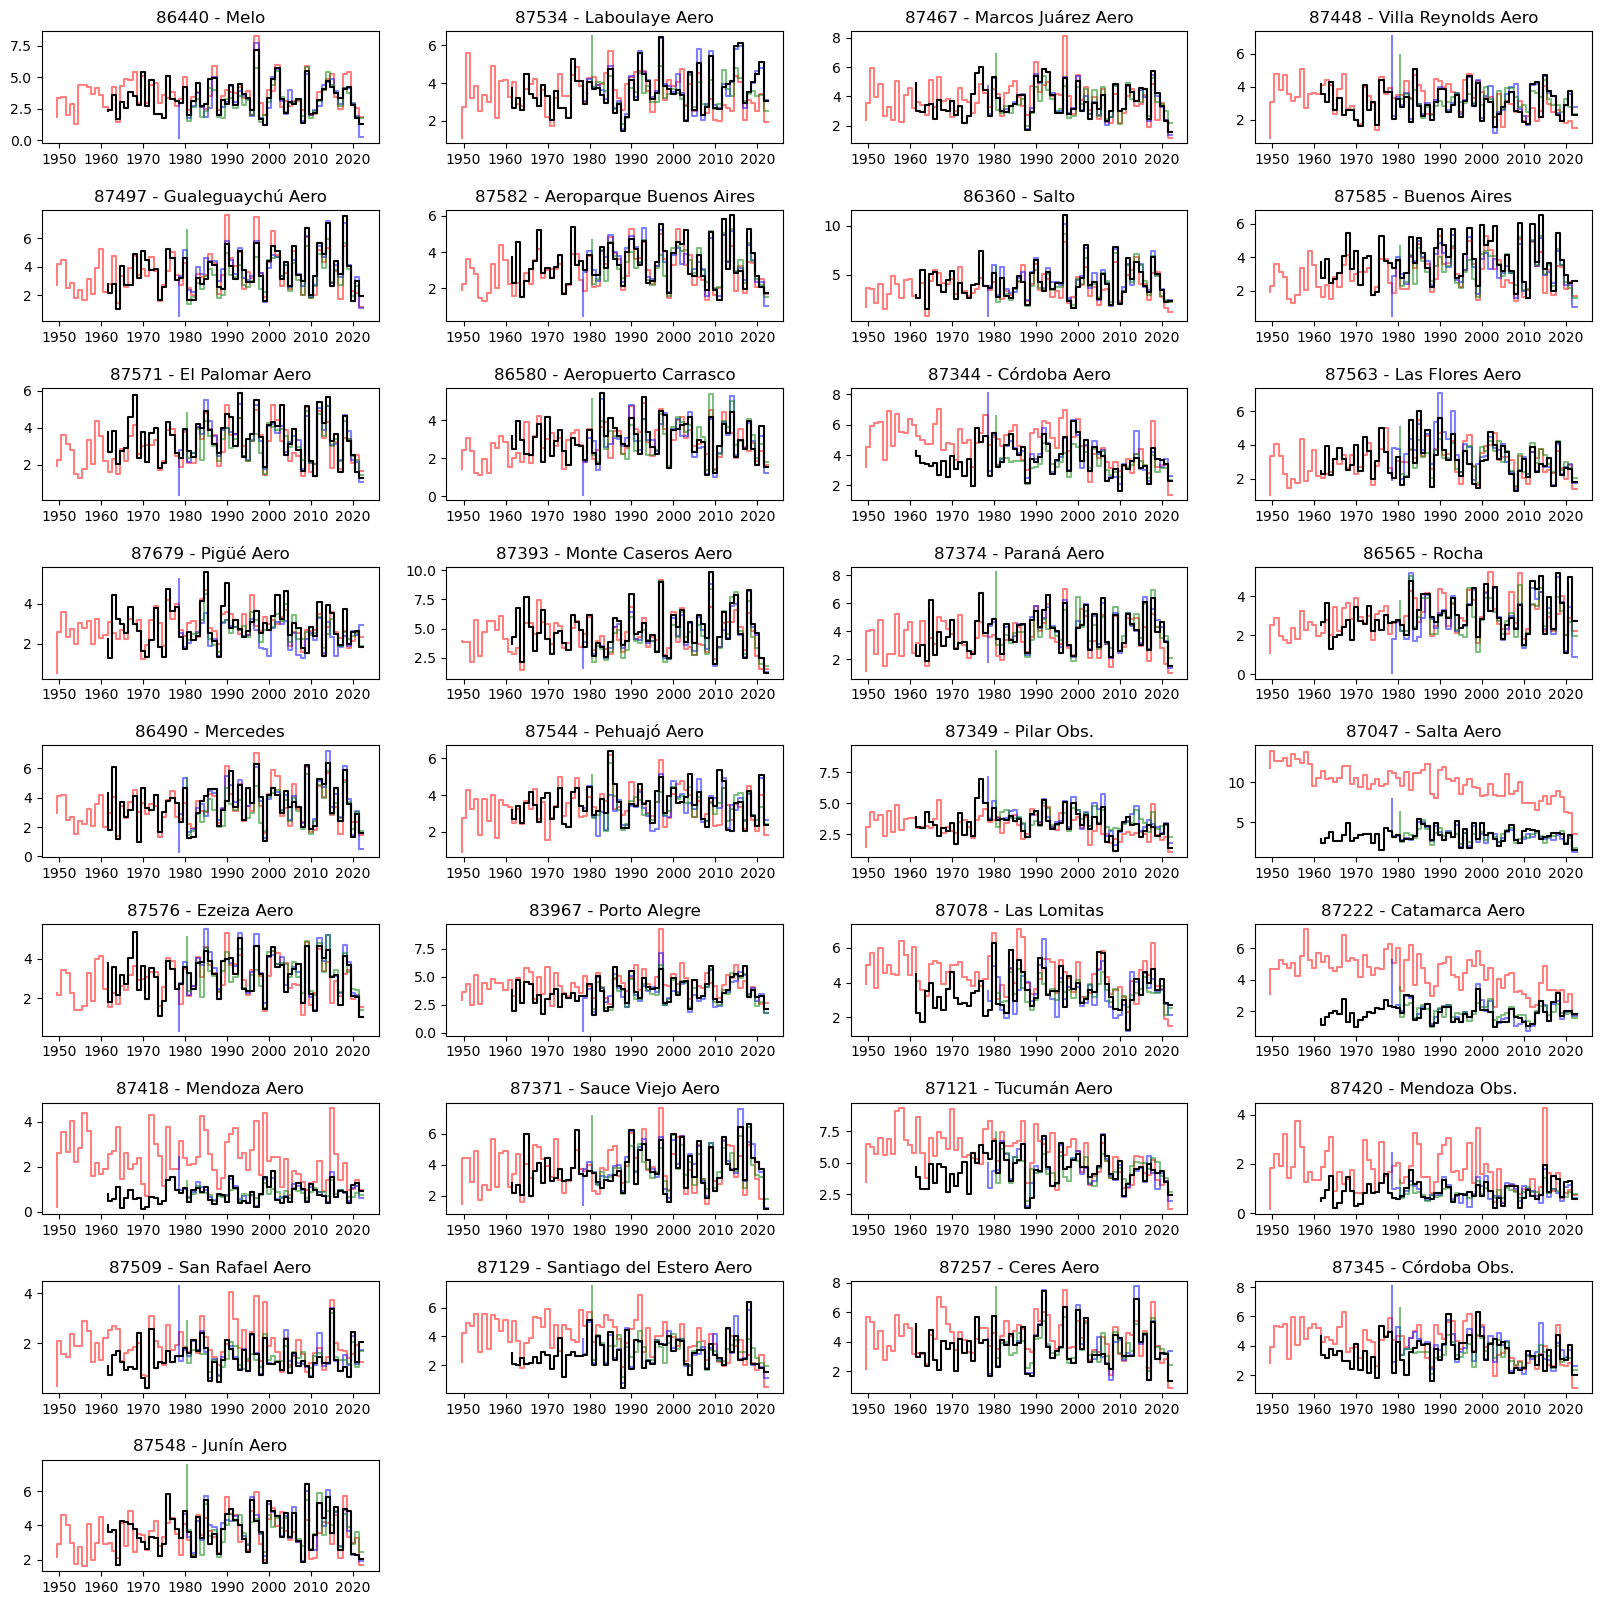

In [125]:
fig, axs = plt.subplots(ncols = 4, nrows = 9, figsize = (20,20), dpi = 100)
plt.subplots_adjust(hspace = 0.6)

for i in range(obs.shape[1]):
    
    stn = obs.columns[i]
    ax = fig.axes[i]
    
    ax.step(era5.index, era5[[stn]], color = "red", alpha = 0.5)
    ax.step(cpc.index, cpc[[stn]], color = "blue", alpha = 0.5)
    ax.step(chirps.index, chirps[[stn]], color = "green", alpha = 0.5)
    ax.step(obs.index, obs[[stn]], color = "k")
    
    ax.set_xlabel("")
    ax.set_title(stn+" - "+gdf.loc[int(stn)].nombre)
    
for i in range(df.shape[1], axs.shape[0] * axs.shape[1]): fig.axes[i].set_axis_off()

plt.savefig("station-validation.png")

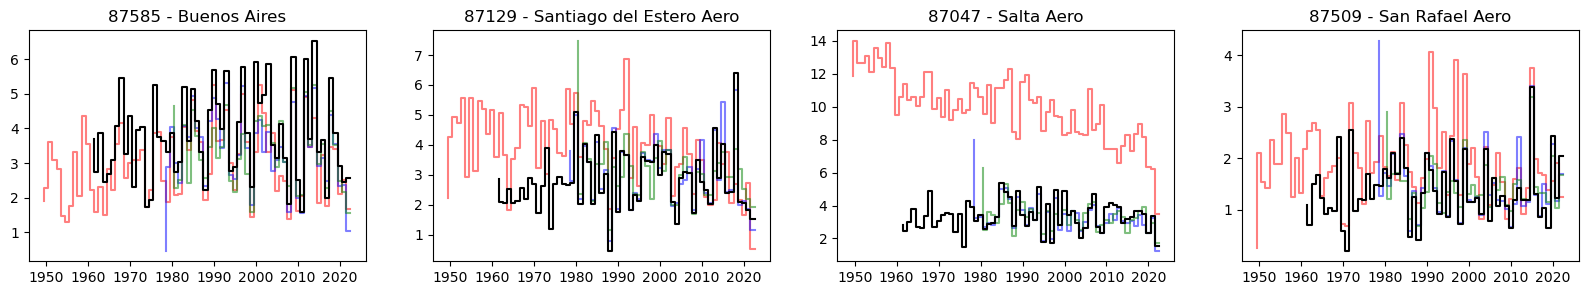

In [142]:
stn_sel = [str(s) for s in [87585, 87129, 87047, 87509]] 
obs_sel = obs.loc[:,stn_sel]

fig, axs = plt.subplots(ncols = 4, figsize = (20,3), dpi = 100)
plt.subplots_adjust(hspace = 0.6)

for i in range(obs_sel.shape[1]):
    
    stn = obs_sel.columns[i]
    ax = fig.axes[i]
    
    ax.step(era5.index, era5[[stn]], color = "red", alpha = 0.5)
    ax.step(cpc.index, cpc[[stn]], color = "blue", alpha = 0.5)
    ax.step(chirps.index, chirps[[stn]], color = "green", alpha = 0.5)
    ax.step(obs.index, obs[[stn]], color = "k")
    
    ax.set_xlabel("")
    ax.set_title(stn+" - "+gdf.loc[int(stn)].nombre)
    
plt.savefig("station-validation-examples.png")

In [10]:
eff_pr = (xr.open_dataset("data/cpc_precip_monthly.nc").precip - xr.open_dataset("data/cpc_pet_monthly.nc").pet)

In [16]:
eff_pr = eff_pr.rolling(time = 3).mean().groupby("time.month")[12]

In [18]:
sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())
rm = regionmask.mask_3D_geopandas(sf, eff_pr.lon, eff_pr.lat).squeeze(drop = True)

---
## **Further analysis**

### **SPI at different durations**

#### **Time series**

In [297]:
pr = xr.open_dataset("data/chirps_CSA_daily.nc").precip.resample(time = "MS").mean()

def q_spi(da, nm):
    
    da_nm = da.rolling(time = nm, center = False).mean().groupby("time.month")[12]
    pars = fit(da_nm.sel(time = slice("1980", "2010")).copy().dropna("time", "all"), dist = "gamma", method = "PWM")
    spi = xr.apply_ufunc(lambda pr, dparams : norm.ppf(gamma.cdf(pr, *dparams)), da_nm, pars, 
                               input_core_dims = [["time"],["dparams"]], output_core_dims = [["time"]], vectorize = True).assign_coords(time = da_nm.time)
    return(spi)

spi = xr.concat([q_spi(pr, nm).expand_dims(nmonths = [nm]) for nm in [3,6,12,24,36,48]], "nmonths")

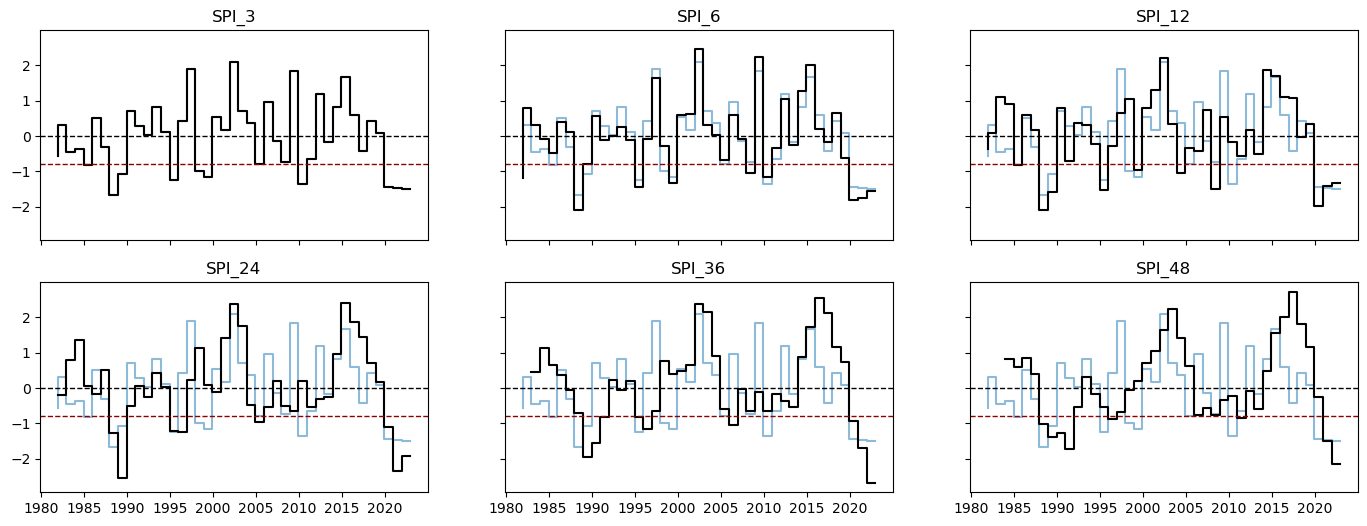

In [299]:
fig,axs = plt.subplots(ncols = 3, nrows = 2, figsize = (17,6), dpi = 100, sharex = True, sharey = True)

for i in range(len(spi.nmonths)):
    
    ax = fig.axes[i]
    spi_n = spi.isel(nmonths = i).squeeze()
    ax.step(spi.time, spi.sel(nmonths = 3), color = "tab:blue", alpha = 0.5)
    ax.step(spi_n.time, spi_n, color = "k")
    ax.set_title("SPI_"+str(spi_n.nmonths.values))
    ax.axhline(0, color = "k", lw = 1, ls = "--")
    ax.axhline(-0.8, color = "darkred", lw = 1, ls = "--")

#### **Maps**

In [300]:
pr_map = xr.open_dataset("data/chirps_precip_monthly.nc").precip
spi_map = xr.concat([q_spi(pr_map, nm).expand_dims(nmonths = [nm]) for nm in [3,6,12,24,36,48]], "nmonths")

cmap = matplotlib.colors.ListedColormap(['darkred', 'red', 'orange', 'gold','yellow']); cmap.set_over('honeydew')
cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.07, "shrink" : 0.85, "label" : "Drought classification", "ticks" : list(range(1,6))}
plot_kwargs = {"cmap" : cmap, "norm" : matplotlib.colors.BoundaryNorm(np.arange(0.5,6.5,1), cmap.N), "add_colorbar" : False}

sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

Text(0.5, 0.98, 'Classification of SPI droughts of different duration ending in December 2022 (CHIRPS)')

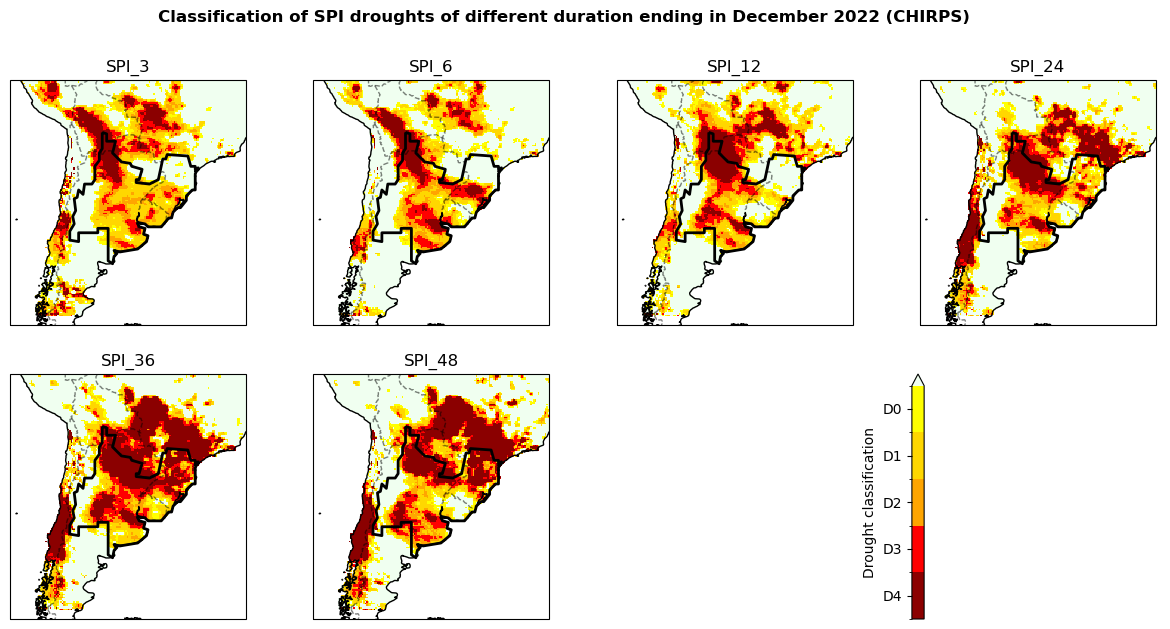

In [301]:
fig,axs = plt.subplots(ncols = 4, nrows = 2, figsize = (15,7), dpi = 100, sharex = True, sharey = True, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

if len(spi_map.nmonths) < len(fig.axes): 
    for i in range(len(spi_map.nmonths), len(fig.axes)): fig.axes[i].set_axis_off()
    
for i in range(len(spi_map.nmonths)):
    
    ax = fig.axes[i]
    spi_nm = spi_map.isel(nmonths = i, time = -1, drop = True)
    dc = xr.apply_ufunc(np.digitize, spi_nm, kwargs={'bins': [-np.inf, -2, -1.55, -1.25, -.75, -.5]}).where(~np.isnan(spi_nm))
    cbar = dc.plot(ax = ax, **plot_kwargs)
    ax.coastlines()
    ax.set_extent((-80,-40, -49.75,-10))
    ax.set_title("SPI_"+str(spi_map.nmonths.values[i]))
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
    
    sf.boundary.plot(ax = ax, color = "k", lw = 2)
    
cbar = plt.colorbar(cbar, ax = axs[-1,-1], location = "left", fraction = 0.05, pad = 0, ticks=list(range(1,6)), extend = "max", label = "Drought classification")
cbar.ax.set_yticklabels(["D" + str(x) for x in range(4,-1,-1)])

plt.suptitle("Classification of SPI droughts of different duration ending in December 2022 (CHIRPS)", fontweight = "bold")

In [20]:
# load latest data, discretize to get drought classifications
spi = {ens : xr.open_dataset("data/"+ens+"_spi3_monthly.nc").spi.sel(time = "2022-12").squeeze(drop = True) for ens in ["mswep"]}
spi = {k : xr.apply_ufunc(np.digitize, v, kwargs={'bins': [-np.inf, -2, -1.55, -1.25, -.75, -.5]}).where(~np.isnan(v)) for k, v in spi.items()}

obs = pd.read_csv("station-timeseries.csv", index_col = "fecha", parse_dates = True)[[str(s) for s in [83967, 87047, 87078, 87129, 87345, 87480, 87509, 87585, 87641]]].resample("MS").mean()
gdf = pd.read_csv("station-data.csv", index_col ="omm_id").loc[[int(c) for c in obs.columns]]

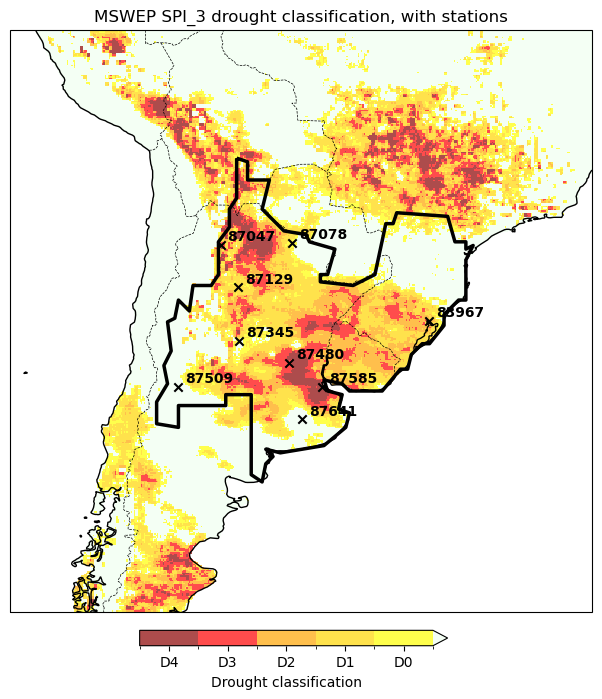

In [22]:
sf = gpd.read_file("sf_CSA-drought").to_crs(cartopy.crs.PlateCarree())

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

cmap = matplotlib.colors.ListedColormap(['darkred', 'red', 'orange', 'gold','yellow']); cmap.set_over('honeydew')
cbar_kwargs = {"location" : "bottom", "fraction" : 0.04, "pad" : 0.07, "shrink" : 0.85, "label" : "Drought classification", "ticks" : list(range(1,6))}
plot_kwargs = {"cmap" : cmap, "norm" : matplotlib.colors.BoundaryNorm(np.arange(0.5,6.5,1), cmap.N), "add_colorbar" : False}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
i = 0
n_ens = len(spi.keys())
fig, ax = plt.subplots(ncols = n_ens, subplot_kw = {"projection" : cartopy.crs.PlateCarree()}, dpi = 100, figsize = (n_ens*4*2,4*2))
        
ens = list(spi.keys())[i]
cbar = spi[ens].plot(ax = ax, **plot_kwargs, alpha = 0.7)
ax.set_title(ens.upper()+" SPI_3 drought classification, with stations")

sf.boundary.plot(ax = ax, color = "k", lw = 2.5)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 1, lw = 0.5)

ax.scatter(gdf.longitud, gdf.latitud, marker = "x", color = "k")
[ax.annotate(str(k), xy = [v.longitud, v.latitud], textcoords="offset points", xytext=(5,3), ha = 'left', fontweight = "bold") for k,v in gdf.iterrows()]

cbar = plt.colorbar(cbar, ax = ax, location = "bottom", fraction = 0.025, pad = 0.03, ticks=list(range(1,6)), extend = "max", label = "Drought classification")
cbar.ax.set_xticklabels(["D" + str(x) for x in range(4,-1,-1)])

# plt.suptitle("Drought classification in December 2022 based on 3-month SPI", fontweight = "bold", y = 1.02)

plt.savefig("station-map-"+ens+".png")

---
### **JAS-OND precipitation gradient**

Original idea: To take the accumulated precipitation during (for example) July-August-September as baseline and to calculate the precipitation anomaly during October-November-December. Having a look of the temporal evolution of these anomalies might led to a quantification of any trend towards a fast precipitation decline over time. The thing is that winter (and also autumn) were also dry as consequence of La Niña, thus we won't find any significant decline in precipitation over the last quarter of the year. And considering that multiyear droughts are also a common feature due to La Niña influence, I'm sure it would happen during other years in the precipitation record. If the only way to perform an attribution study is through the evaluation of trends, that would be very sensitive to the length of the data and the period considered, as in this case were trends can be considered either negative or negligible in the observations but models tend to show a positive trend. The other factor that we are not considering (as far as I know) is how climate change is affecting precipitation variability on time scales shorter than decadal trends. That aspect is relevant for example for the evaluation of droughts that are increasing in severity and area over shorts periods of time, as in this case study.

Text(0.5, 1.0, 'OND precip as proportion of JAS precip (CHIRPS)')

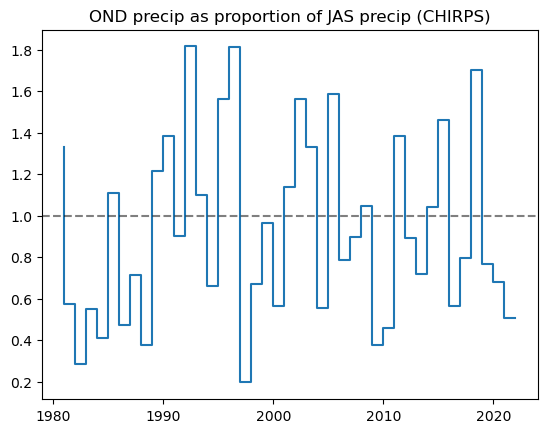

In [221]:
pr = xr.open_dataset("data/chirps_CSA_daily.nc").precip.resample(time = "MS").mean()

pr_jas = pr.rolling(time = 3, center = False).mean().groupby("time.month")[9]
pr_ond = pr.rolling(time = 3, center = False).mean().groupby("time.month")[12]

pr_jas, pr_ond = [da.assign_coords(time = da.time.dt.year) for da in [pr_jas, pr_ond]]
plt.step(pr_jas.time, (pr_ond - pr_jas) / pr_jas)

plt.axhline(1, ls = "--", alpha = 0.5, color = "k")
plt.title("OND precip as proportion of JAS precip (CHIRPS)")

In [310]:
obs = pd.read_csv("station-timeseries.csv", index_col = "fecha", parse_dates = True)[[str(s) for s in [83967, 87047, 87078, 87129, 87345, 87480, 87509, 87585, 87641]]].resample("MS").mean()
gdf = pd.read_csv("station-data.csv", index_col ="omm_id").loc[[int(c) for c in obs.columns]]

obs_jas = obs.rolling(3, center = False).mean().loc[obs_3m.index.month == 9]
obs_ond = obs.rolling(3, center = False).mean().loc[obs_3m.index.month == 12]

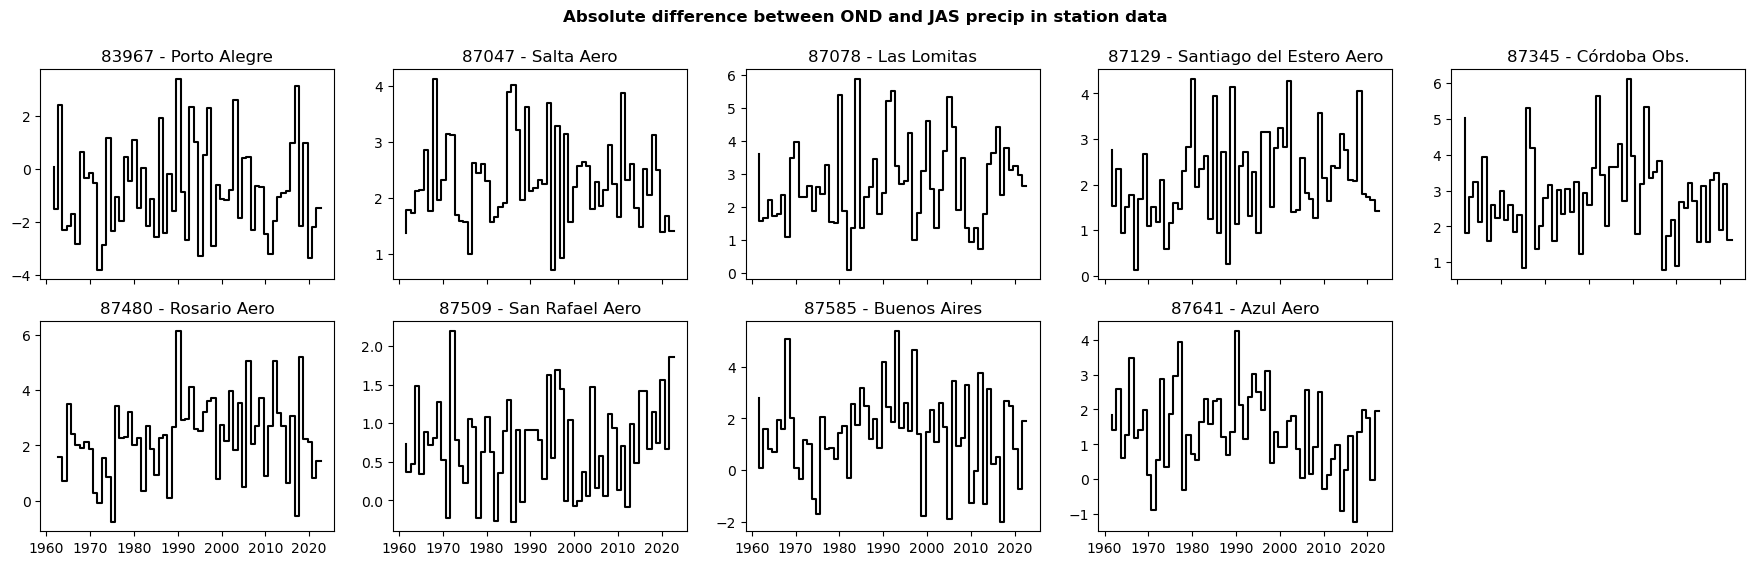

In [324]:
fig,axs = plt.subplots(ncols = 5, nrows = 2, figsize = (22,6), dpi = 100, sharex = True, sharey = False)

for i in range(len(obs_jas.columns)):
    
    ax = fig.axes[i]
    stn = obs.columns[i]
    
    ax.step(obs_jas.index, ((obs_ond.values - obs_jas))[[stn]], color = "k")
    ax.set_title(stn+" - "+gdf.loc[int(stn), "nombre"])
    # ax.axhline(1, color = "k", lw = 1, ls = "--", alpha = 0.5)
    # ax.axhline(0, color = "darkred", lw = 1, ls = "--", alpha = 0.5)
    
axs[-1,-1].set_axis_off()

plt.suptitle("Absolute difference between OND and JAS precip in station data", fontweight = "bold")
plt.savefig("ond-jas-diff.png")

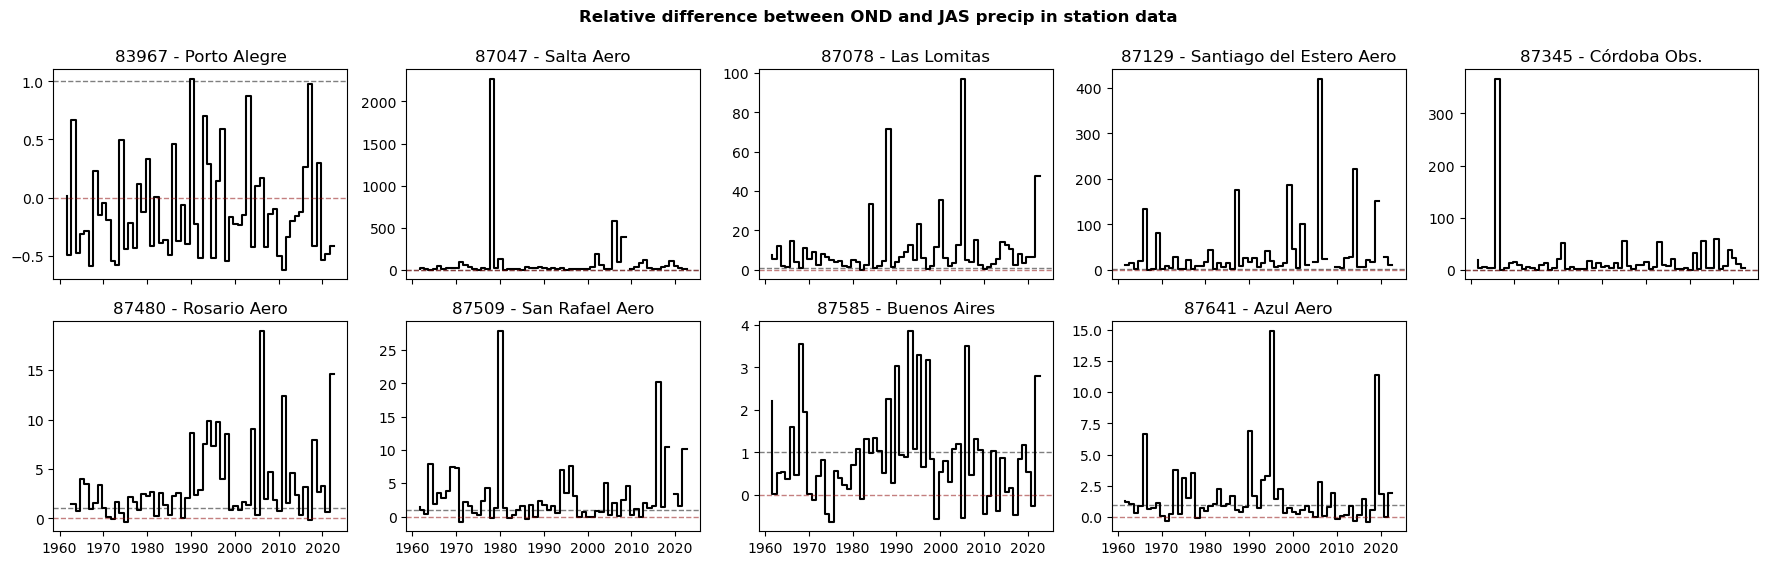

In [331]:
fig,axs = plt.subplots(ncols = 5, nrows = 2, figsize = (22,6), dpi = 100, sharex = True, sharey = False)

for i in range(len(obs_jas.columns)):
    
    ax = fig.axes[i]
    stn = obs.columns[i]
    
    ax.step(obs_jas.index, ((obs_ond.values - obs_jas)/obs_jas)[[stn]], color = "k")
    ax.set_title(stn+" - "+gdf.loc[int(stn), "nombre"])
    ax.axhline(1, color = "k", lw = 1, ls = "--", alpha = 0.5)
    ax.axhline(0, color = "darkred", lw = 1, ls = "--", alpha = 0.5)
    
axs[-1,-1].set_axis_off()

plt.suptitle("Relative difference between OND and JAS precip in station data", fontweight = "bold")
plt.savefig("ond-jas-reldiff.png")